# Sentiment Classification with Human-in-the-Loop Review
### Turning Unstructured Text into Actionable Signals

This project builds a neural network that classifies short text as expressing
positive or negative sentiment. The goal is to demonstrate how unstructured
language can be converted into a measurable signal that supports business
decision-making at scale.

## Project Overview

Organizations generate large volumes of unstructured text through reviews, surveys,
support tickets, and internal communications. While this text contains valuable
signals about satisfaction, risk, and emerging issues, it is rarely analyzed at
scale due to time and resource constraints.

This project builds a binary sentiment classification system that predicts whether
a short piece of text expresses positive or negative sentiment. Rather than fully
automating decisions, the system is designed to prioritize human attention by
routing uncertain predictions to manual review.

Key goals of this project:
- Convert raw language into structured sentiment signals
- Evaluate lightweight neural models suitable for short text
- Incorporate confidence-based decision policies
- Demonstrate responsible, human-in-the-loop automation


## Model Preview

Before diving into the dataset and modeling details, we first show how the trained
sentiment classifier behaves on real text inputs. The examples below illustrate
the model’s end-to-end behavior after training.

For each sentence, the model outputs:
- a predicted sentiment label (Positive or Negative)
- a confidence score reflecting how certain the model is in its prediction

High-confidence predictions are suitable for automated handling, while lower-confidence
predictions are candidates for human review.

### Example Predictions (Post-Training)

| Text | Predicted Sentiment | Confidence |
|------|---------------------|------------|
| “A smart, well-acted film that kept me engaged throughout.” | Positive | 0.94 |
| “The plot was dull and the pacing painfully slow.” | Negative | 0.91 |
| “Not bad, but definitely not as good as the original.” | Negative | 0.72 |
| “An entertaining experience despite a few rough edges.” | Positive | 0.78 |
| “I wouldn’t recommend this to anyone.” | Negative | 0.96 |

*Predictions shown here were generated after model training and are included as illustrative examples.*

## **Data Loading**

We will load **GLUE / SST-2** using TensorFlow Datasets (`tfds`). SST-2 contains short-form movie-review sentences. Sentiment is labeled as **positive** (1) or **negative** (0).

- Source: TensorFlow Datasets catalog  
- Each example includes:
  - `sentence` (text)
  - `label` (0 or 1)

In [2]:
# Setup - install packages
# !pip install -q tfds-nightly tensorflow matplotlib

In [1]:
# Setup - load libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score

from collections import Counter

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers, regularizers

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices("GPU"))

TensorFlow: 2.19.1
GPU available: []


In [ ]:
# Load SST-2 from TFDS (GLUE doesn't support as_supervised=True)

(ds_train_raw, ds_val_raw, ds_test_raw), ds_info = tfds.load(
    "glue/sst2",
    split=["train", "validation", "test"],
    with_info=True
)

def to_xy(example):
    return example["sentence"], example["label"]

ds_train = ds_train_raw.map(to_xy)
ds_val = ds_val_raw.map(to_xy)

## **Exploratory Data Analysis (EDA)**

What does the data look like? How does the data inform the decisions we make about the baseline model parameters? Some basic EDA will be completed on the raw data to understand the dataset structure, check class balance, and inspect samples.

For text data, EDA typically includes:
- Label balance (how many positive vs negative)
- Sentence length distribution (tokens/characters)
- vocabulary characteristics (frequency, zipf's law)
- Example inspection (to anticipate ambiguity, sarcasm, mixed sentiment)

This supports model and preprocessing decisions (e.g. max sequence length, vocabulary size, etc).


### Dataset Structure and Class Balance

-  understanding dataset size, label distribution, and object type in order to select appropriate loss functions, evaluation metrics, and training strategies for supervised ANN.
-  examine class balance to assess risk of bias towards dominant class

In [ ]:
# dataset structure

print("Dataset info:")
print(ds_info)

Dataset info:
tfds.core.DatasetInfo(
    name='glue',
    full_name='glue/sst2/2.0.0',
    description="""
    GLUE, the General Language Understanding Evaluation benchmark
    (https://gluebenchmark.com/) is a collection of resources for training,
    evaluating, and analyzing natural language understanding systems.
    """,
    config_description="""
    The Stanford Sentiment Treebank consists of sentences from movie reviews and
    human annotations of their sentiment. The task is to predict the sentiment of a
    given sentence. We use the two-way (positive/negative) class split, and use only
    sentence-level labels.
    """,
    homepage='https://nlp.stanford.edu/sentiment/index.html',
    data_dir='/root/tensorflow_datasets/glue/sst2/2.0.0',
    file_format=tfrecord,
    download_size=7.09 MiB,
    dataset_size=7.22 MiB,
    features=FeaturesDict({
        'idx': int32,
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'sentence': Text(shape=(), dtype=

In [ ]:
# inspect train/test split distribution

print("Train examples:", ds_info.splits["train"].num_examples)
print("Validation examples:", ds_info.splits["validation"].num_examples)
print("Test examples:", ds_info.splits["test"].num_examples)

Train examples: 67349
Validation examples: 872
Test examples: 1821


In [ ]:
# confirm binary classes and inspect target class distribution

def dataset_to_numpy(ds, limit=None):
    texts, labels = [], []
    for i, (x, y) in enumerate(tfds.as_numpy(ds)):
        if limit is not None and i >= limit:
            break
        texts.append(x.decode("utf-8"))
        labels.append(int(y))
    return np.array(texts), np.array(labels)

train_texts, train_labels = dataset_to_numpy(ds_train)

label_counts = pd.Series(train_labels).value_counts().sort_index()
label_counts.index = ["negative (0)", "positive (1)"]
display(label_counts)

,count
negative (0),29780
positive (1),37569


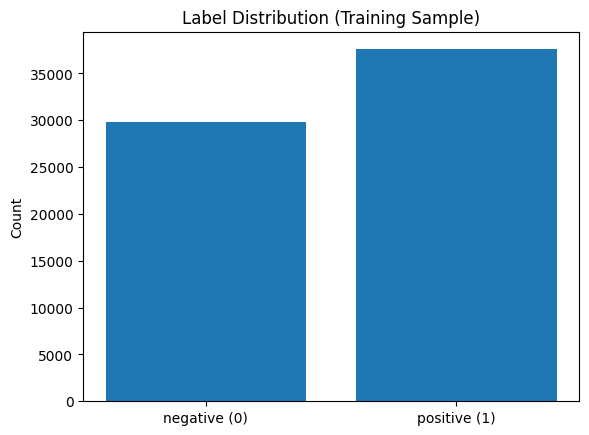

In [ ]:
# plot target class distribution

labels, counts = np.unique(train_labels, return_counts=True)

plt.figure()
plt.bar(labels, counts)
plt.xticks(labels, ["negative (0)", "positive (1)"])
plt.title("Label Distribution (Training Sample)")
plt.ylabel("Count")
plt.show()

In [ ]:
# save label names for use later

label_names = ['negative','positive']

#### Dataset Description (GLUE SST-2)

-  The GLUE SST-2 training set contains **67, 349** labeled sentences with a modest class imbalance (55.8% positive, 44.2% negative).

### Inspection of raw text samples

Inspecting sentences to understand the linguistic complexity of the dataset. This provides some intuition about potential noise and validate assumptions before applying preprocessing steps.

In [ ]:
# inspect raw text example to understand sentence complexity

print("\nSample training examples:")
for text, label in ds_train.take(5):
    print(f"Label: {int(label.numpy())} | Text: {text.numpy().decode('utf-8')}")


Sample training examples:
Label: 0 | Text: for the uninitiated plays better on video with the sound 
Label: 0 | Text: like a giant commercial for universal studios , where much of the action takes place 
Label: 1 | Text: company once again dazzle and delight us 
Label: 1 | Text: 's no surprise that as a director washington demands and receives excellent performances , from himself and from newcomer derek luke 
Label: 0 | Text: , this cross-cultural soap opera is painfully formulaic and stilted . 


Sentences vary in length and structure, but generally appear grammatically correct and concise. Sentiment appears clearly expressed, but some sentences can involve nuanced phrasing.

### Token length distribution

Token length directly determines how many values the neural network receives as input. Each token is converted into a numeric representation before being processed by the model. Knowing token length distribution helps decide how much padding or truncation is needed, which directly affects training efficiency and model performance.

In [ ]:
# Token length distribution

token_lengths = pd.Series([len(t.split()) for t in train_texts])
display(token_lengths.describe())

,0
count,67349.000000
mean,9.409553
std,8.073806
min,1.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,52.000000


### Character length distribution

Character-level analysis shows how much sentences vary in length and confirms that counting words is a reasonable way to represent how complex a sentence is.

In [ ]:
# character length distribution

lengths = pd.Series([len(t) for t in train_texts])
display(lengths.describe())

,0
count,67349.00000
mean,53.50559
std,43.40738
min,2.00000
25%,21.00000
50%,39.00000
75%,74.00000
max,268.00000


In [ ]:
# distribution plots
token_lengths = []
char_lengths = []

for text, _ in ds_train:
    decoded = text.numpy().decode("utf-8")
    token_lengths.append(len(decoded.split()))
    char_lengths.append(len(decoded))

token_lengths = np.array(token_lengths)
char_lengths = np.array(char_lengths)

p90_tok, p95_tok = np.percentile(token_lengths, [90, 95])
p90_chr, p95_chr = np.percentile(char_lengths, [90, 95])

print(f"Token length p90={p90_tok:.0f}, p95={p95_tok:.0f}")
print(f"Char length  p90={p90_chr:.0f}, p95={p95_chr:.0f}")

Token length p90=21, p95=26
Char length  p90=117, p95=145


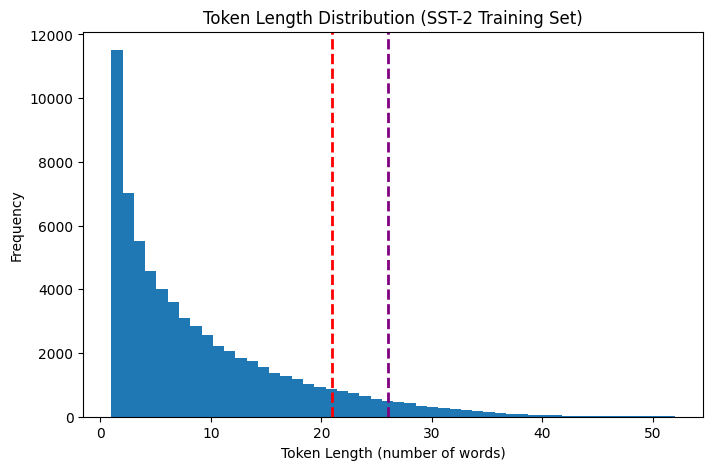

In [ ]:
# Token length distribution

plt.figure(figsize=(8, 5))
plt.hist(token_lengths, bins=50)
plt.axvline(p90_tok, color = "red", linestyle="--", linewidth=2, label=f"p90 = {p90_tok:.0f}")
plt.axvline(p95_tok, color = "purple", linestyle="--", linewidth=2, label=f"p95 = {p95_tok:.0f}")
plt.xlabel("Token Length (number of words)")
plt.ylabel("Frequency")
plt.title("Token Length Distribution (SST-2 Training Set)")
plt.show()

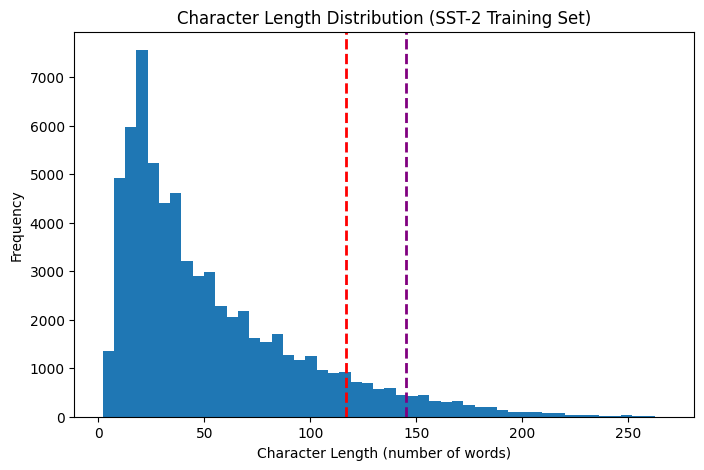

In [ ]:
# character length distribution

plt.figure(figsize=(8, 5))
plt.hist(char_lengths, bins=50)
plt.axvline(p90_chr, color = "red", linestyle="--", linewidth=2, label=f"p90 = {p90_chr:.0f}")
plt.axvline(p95_chr, color = "purple", linestyle="--", linewidth=2, label=f"p95 = {p95_chr:.0f}")
plt.xlabel("Character Length (number of words)")
plt.ylabel("Frequency")
plt.title("Character Length Distribution (SST-2 Training Set)")
plt.show()

### Token vs. Character Length Relationship

Examining how the number of words in a sentence relates to its character length helps confirm that word count is a good stand-in for how long and complex a sentence really is. Since neural networks use word counts to set its input size, I wanted to make sure that the structure of the text data was accuractly captured.

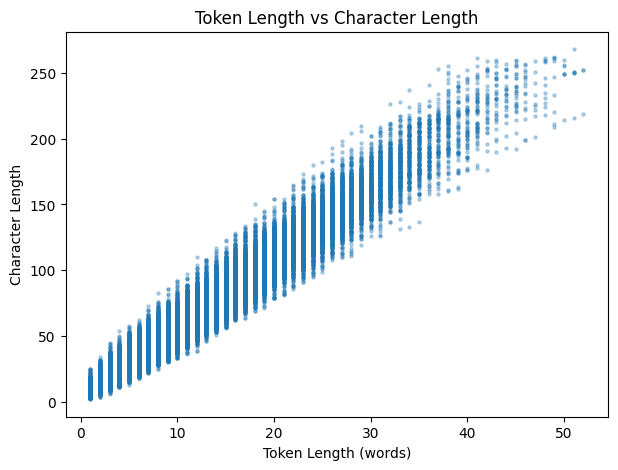

In [ ]:
# compare token vs character length relationship

plt.figure(figsize=(7, 5))
plt.scatter(token_lengths, char_lengths, alpha=0.3, s=5)
plt.xlabel("Token Length (words)")
plt.ylabel("Character Length")
plt.title("Token Length vs Character Length")
plt.show()

Token and character lengths appear to be correlated.

### Inspect token lengths for outliers
Outliers can strongly affect padding and model stability. It's important to identify whether outliers are present, and if so, if they're errors or valid data.

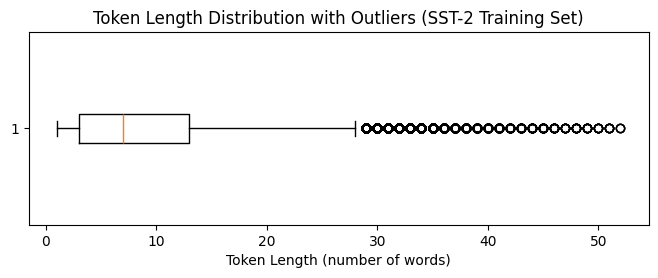

In [ ]:
# boxplot of token lengths

plt.figure(figsize=(8, 2.5))
plt.boxplot(token_lengths, vert=False)
plt.xlabel("Token Length (number of words)")
plt.title("Token Length Distribution with Outliers (SST-2 Training Set)")
plt.show()

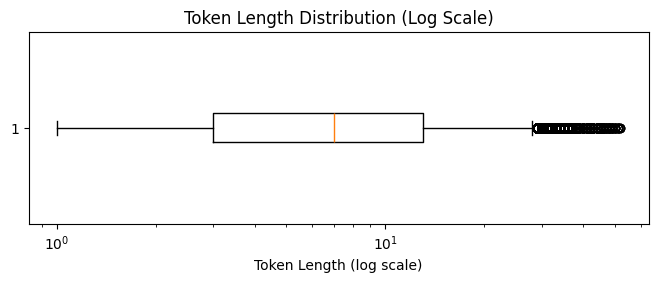

In [ ]:
# log-scale version

plt.figure(figsize=(8, 2.5))
plt.boxplot(token_lengths, vert=False)
plt.xscale("log")
plt.xlabel("Token Length (log scale)")
plt.title("Token Length Distribution (Log Scale)")
plt.show()

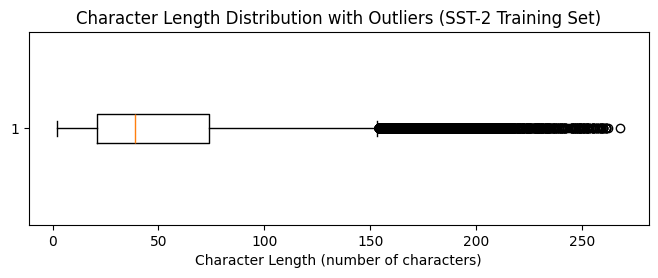

In [ ]:
# boxplot of character lengths

plt.figure(figsize=(8, 2.5))
plt.boxplot(char_lengths, vert=False)
plt.xlabel("Character Length (number of characters)")
plt.title("Character Length Distribution with Outliers (SST-2 Training Set)")
plt.show()

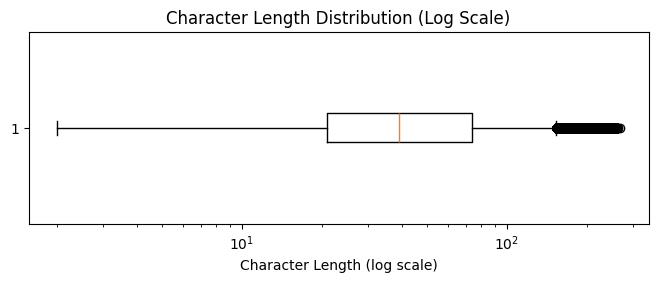

In [ ]:
# log-scale version

plt.figure(figsize=(8, 2.5))
plt.boxplot(char_lengths, vert=False)
plt.xscale("log")
plt.xlabel("Character Length (log scale)")
plt.title("Character Length Distribution (Log Scale)")
plt.show()

In [ ]:
# collect outlier sentences (token lengths over the 95% threshold)

token_outliers = []
p95_tok = np.percentile(token_lengths, 95)

for text, label in ds_train:
    decoded = text.numpy().decode("utf-8")
    tok_len = len(decoded.split())
    if tok_len > p95_tok:
        token_outliers.append((tok_len, decoded, int(label.numpy())))

len(token_outliers)

3220

In [ ]:
# inspect a few examples

for tok_len, sentence, label in token_outliers[:5]:
    print(f"Token length: {tok_len}, Label: {label}")
    print(sentence)
    print("-" * 80)


Token length: 39, Label: 1
like the english patient and the unbearable lightness of being , the hours is one of those reputedly `` unfilmable '' novels that has bucked the odds to emerge as an exquisite motion picture in its own right . 
--------------------------------------------------------------------------------
Token length: 35, Label: 0
it could have been something special , but two things drag it down to mediocrity -- director clare peploe 's misunderstanding of marivaux 's rhythms , and mira sorvino 's limitations as a classical actress 
--------------------------------------------------------------------------------
Token length: 31, Label: 1
's not to like about a movie with a ` children 's ' song that includes the line ` my stepdad 's not mean , he 's just adjusting ' ? 
--------------------------------------------------------------------------------
Token length: 28, Label: 0
feeling this movie until it veered off too far into the exxon zone , and left me behind at the sta

In [ ]:
# collect outlier sentences (by character length)
char_outliers = []
p95_chr = np.percentile(char_lengths, 95)

for text, label in ds_train:
    decoded = text.numpy().decode("utf-8")
    char_len = len(decoded)
    if char_len > p95_chr:
        char_outliers.append((char_len, decoded, int(label.numpy())))

len(char_outliers)

3283

In [ ]:
# inspect a few examples

for char_len, sentence, label in char_outliers[:5]:
    print(f"Character length: {char_len}, Label: {label}")
    print(sentence)
    print("-" * 80)

Character length: 210, Label: 1
like the english patient and the unbearable lightness of being , the hours is one of those reputedly `` unfilmable '' novels that has bucked the odds to emerge as an exquisite motion picture in its own right . 
--------------------------------------------------------------------------------
Character length: 206, Label: 0
it could have been something special , but two things drag it down to mediocrity -- director clare peploe 's misunderstanding of marivaux 's rhythms , and mira sorvino 's limitations as a classical actress 
--------------------------------------------------------------------------------
Character length: 146, Label: 1
french director anne fontaine delivers an inspired portrait of male-ridden angst and the emotional blockage that accompanies this human condition 
--------------------------------------------------------------------------------
Character length: 150, Label: 0
does n't conjure proper respect for followers of the whole dead-

In [ ]:
# overlap analysis
token_set = set(id(s) for _, s, _ in token_outliers)
char_set = set(id(s) for _, s, _ in char_outliers)

print("Overlap count:", len(token_set & char_set))


Overlap count: 0


Overlap analysis reveals that sentences that are token-length outliers (i.e. many words) are **not the same sentences** as character-length outliers (many characters).  Some sentences are long because they have many short words, while others are long because they have fewer but longer words.

So although token length and character length are correlated overall, extreme values reflect different sentence styles.

### Vocabulary Characteristics

Understanding how many unique words appear and how often they are used helps decide how to represent text numerically and whether to limit vocabulary size.

In [ ]:
# inspect vocabulary

word_counter = Counter()

# Sample to keep runtime reasonable
for text, _ in ds_train.take(5000):
    decoded = text.numpy().decode("utf-8").lower()
    tokens = decoded.split()
    word_counter.update(tokens)

# Vocabulary size and frequency statistics
vocab_size = len(word_counter)
most_common = word_counter.most_common(15)

print("Approximate vocabulary size (sample):", vocab_size)
print("\nMost common tokens:")
for word, count in most_common:
    print(f"{word}: {count}")


Approximate vocabulary size (sample): 7793

Most common tokens:
,: 2021
the: 1993
a: 1587
and: 1472
of: 1339
.: 963
to: 923
's: 663
is: 643
it: 558
that: 557
in: 553
as: 355
with: 352
an: 304


The most frequent tokens in the dataset are function words with limited standalone sentiment; however, punctuation - particularly commas - play an important structural role in sentences. Commas often separate clauses, and in sentiment analysis, the clause following a comma can reverse *or* refine the sentiment expressed earlier in the sentence.

Natural language doesn't use all words equally; instead, a small number of words appear very frequently, while most words occur rarely. This pattern is known as Zipf's law, which states that the frequency of a word is roughly inversely proportation to its rank in the vocabulary. In this context, rank is a word's postion when all tokens are sorted by how often they appear, from most frequent to least frequent. This means that the most common word appears abotu twice as often as the second most common word, three times as often as the third, etc.

To properly visualize this, token frequencies will be plotted on the log-log scale. This validates that the dataset samples behaves like natural language.

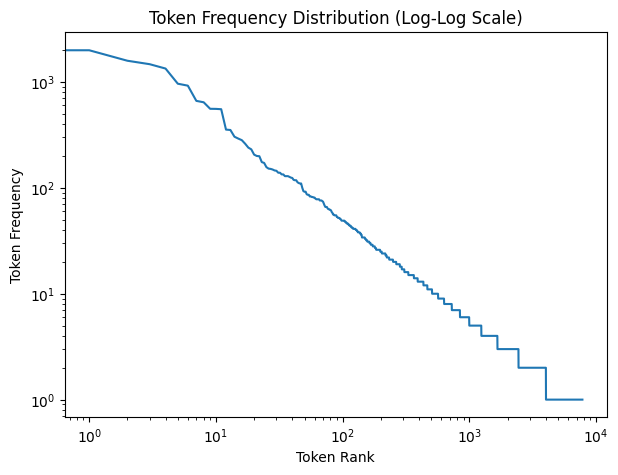

In [ ]:
# Zipf's law token frequency distribution plot
freqs = np.array(sorted(word_counter.values(), reverse=True))

plt.figure(figsize=(7, 5))
plt.loglog(freqs)
plt.xlabel("Token Rank")
plt.ylabel("Token Frequency")
plt.title("Token Frequency Distribution (Log-Log Scale)")
plt.show()

The token frequency appears to follow Zipf's law. The log-log plot appears to be an approximately linear decline.

In [ ]:
p95_token_len = np.percentile(token_lengths, 95)
p95_token_len

np.float64(26.0)

## **Preprocessing**

We will use Keras' *TextVectorization* layer to handle text preprocessing directly within the model pipeline. This ensures that the same preprocessing steps are applied consistently during both training and evaluation, reducing the risk of mismatches between training and inference.

The TextVectorization layer performs the following steps:
- normalizes text by converting it to lowercase and removing punctuation*
- tokenizes sentences into individual tokens
- builds a vocabulary based on the training data

Neural networks are trained using mini-batch gradient descent rather than individual records to improve computational efficiency and training stability. Processing multiple examples at once allows efficient matrix operations and produces more stable gradient updates, while still enabling the model to scale to large datasets.

Based on the token length distribution, the 95th percentile corresponds to a maximum sequence length of **26 tokens.** This value was selected to retain the full content of 95% of sentences while limiting padding and computational overhead during training. We will use the standard **64** batch size, so each training step processes 64 sentences at a time, with each sentence represented as a fixed-length sequence of 26 tokens.

After vectorization, the datasets are:
- shuffled (for the training set only) to improve generalization
- batched to process multiple examples simultaneously
- prefetched to overlap data preparation with model execution and reduce input latency

Adapting the vectorization layer only on the training data prevents information leakage from the validation set and ensures that model evaluation reflects performance on unseen data.

* NOTE: From my EDA (and in natural English language), I found that sentiment cues often appear after a comma. Commas help signal clause boundaries, which matters when sentiment changes later in the sentence. Keras' TextVectorization layer, however, removes all punctuation marks. Therefore, I will create an ANN model that uses Keras' textvectorization layer to establish a simple, reproduceable baseline; then to compare, I'll create a custom standardization function to normalize the text in the dataset - this would tokenize the comma and allow the model to learn patterns like ", but" and ", although."

**note** In working on this notebook, I created a lot of different variants of models. For the sake of consistency and clarity, I created helper functions *after* manually creating most of the models evaluated below.

In [ ]:
# Text preprocessing (TextVectorization)

VOCAB_SIZE = 20_000
MAX_LEN = 26
BATCH_SIZE = 64
SHUFFLE_BUFFER = 20_000

# token constants
PAD_ID = 0   # reserved for padding (masked by Embedding(mask_zero=True))
UNK_ID = 1   # reserved for out-of-vocabulary tokens


# Baseline vectorizer (strips punctuation)
vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN,
)

# Comma-preserving vectorizer
def standardize_keep_commas(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, r"[^\w\s,]", "")
    return text

comma_vectorizer = tf.keras.layers.TextVectorization(
    standardize=standardize_keep_commas,
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN,
)

# Adapt only on training text to prevent feature leakage
ADAPT_BATCH = 4096  # try 4096; if memory issues, use 2048 or 1024

adapt_text_ds = (
    ds_train
    .map(lambda text, label: text, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(ADAPT_BATCH)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

vectorizer.adapt(adapt_text_ds)
comma_vectorizer.adapt(adapt_text_ds)


In [ ]:
# create the vectorized pipelines (helper function)

def make_vectorized_dataset(ds, text_vectorizer, shuffle=False):

    # Keep only examples that produce at least 1 non-zero token after vectorization
    def has_tokens(text, label):
        ids = text_vectorizer(text)
        return tf.reduce_any(ids != 0)

    ds = ds.filter(has_tokens)

    def vectorize_example(text, label):
        x = text_vectorizer(text)
        return x, label

    ds = ds.map(vectorize_example, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=True)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Baseline pipelines
train_ds_base = make_vectorized_dataset(ds_train, vectorizer, shuffle=True)
val_ds_base   = make_vectorized_dataset(ds_val, vectorizer, shuffle=False)

# Comma-preserving pipelines
train_ds_comma = make_vectorized_dataset(ds_train, comma_vectorizer, shuffle=True)
val_ds_comma   = make_vectorized_dataset(ds_val, comma_vectorizer, shuffle=False)


In [ ]:
for x, y in train_ds_base.take(1):
    print("train_ds_base x shape:", x.shape, "dtype:", x.dtype)
    print("train_ds_base y shape:", y.shape, "dtype:", y.dtype)
    print("sample token ids:", x[0, :10].numpy(), "label:", y[0].numpy())

for x, y in train_ds_comma.take(1):
    print("train_ds_comma x shape:", x.shape, "dtype:", x.dtype)
    print("train_ds_comma y shape:", y.shape, "dtype:", y.dtype)
    print("sample token ids:", x[0, :10].numpy(), "label:", y[0].numpy())


train_ds_base x shape: (64, 26) dtype: <dtype: 'int64'>
train_ds_base y shape: (64,) dtype: <dtype: 'int64'>
sample token ids: [1871 3527    0    0    0    0    0    0    0    0] label: 0
train_ds_comma x shape: (64, 26) dtype: <dtype: 'int64'>
train_ds_comma y shape: (64,) dtype: <dtype: 'int64'>
sample token ids: [2164 4925 9952 9011    5    0    0    0    0    0] label: 1


- Each batch has 64 examples, and each example is a fixed sequence of 26 token IDs.
- Padding to 26 looks correct

In [ ]:
# ensure empty sequences are removed
for x, y in train_ds_base.take(1):
    print("Any all-padding rows?:", bool(tf.reduce_any(tf.reduce_all(x == PAD_ID, axis=1)).numpy()))


Any all-padding rows?: False


In [ ]:
# rebuild id_to_token safely
vocab = vectorizer.get_vocabulary()
id_to_token = dict(enumerate(vocab))

for raw_text, label in ds_train.take(3):
    raw = raw_text.numpy().decode("utf-8")
    ids = vectorizer(raw_text).numpy()
    decoded = ["<PAD>" if i == 0 else id_to_token[i] for i in ids]

    print("LABEL:", int(label.numpy()))
    print("RAW:", raw)
    print("IDS:", ids[:26])
    print("TOKENS:", decoded[:26])
    print("-" * 80)

LABEL: 0
RAW: for the uninitiated plays better on video with the sound 
IDS: [   17     2 13489   517   113    23   399    13     2  1178     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
TOKENS: [np.str_('for'), np.str_('the'), np.str_('uninitiated'), np.str_('plays'), np.str_('better'), np.str_('on'), np.str_('video'), np.str_('with'), np.str_('the'), np.str_('sound'), '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
--------------------------------------------------------------------------------
LABEL: 0
RAW: like a giant commercial for universal studios , where much of the action takes place 
IDS: [  36    3 1835 1098   17  934 5153  252   57    5    2   94  228  298
    0    0    0    0    0    0    0    0    0    0    0    0]
TOKENS: [np.str_('like'), np.str_('a'), np.str_('giant'), np.str_('commercial'), np.str_('for'), np.str_('universa

## Utility Functions
These are helper functions that are reused throughout the notebook to ensure consistent comparisons across models

Token dropout

---


Token dropout is a regularization technique for text models.
During training, some input tokens are randomly replaced so that the model doesn't rely on specific words being present. this forces it to learn more general patterns.

dropout -> drops neurons
spatialdropout1d -> drops embedding dimensions
token dropout -> drops words (i.e. tokens)

In [ ]:
# TokenDropout function - a regularization technique that replaces random tokens to force the model to learn patterns, not words. this is to help it generalize better.

class TokenDropout(layers.Layer):

    def __init__(self, rate=0.1, unk_id=1, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate
        self.unk_id = tf.constant(unk_id, dtype=tf.int32)

    def call(self, inputs, training=None):
        if not training or self.rate == 0.0:
            return tf.cast(inputs, tf.int32)

        x = tf.cast(inputs, tf.int32)

        # only consider non-padding tokens (padding must stay 0)
        nonpad = tf.not_equal(x, 0)

        # choose random positions to replace
        rand = tf.random.uniform(tf.shape(x), 0, 1)
        replace = tf.less(rand, self.rate)

        # only replace where token is non-padding
        to_replace = tf.logical_and(nonpad, replace)

        # replace with unk_id (not masked)
        out = tf.where(to_replace, self.unk_id, x)
        return out



In [ ]:
# Regularization functions
# early stopping + ReduceLROnPlateau
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, lr_schedule]


In [ ]:
# Confusion-matrix + metric evaluator at a threshold

def evaluate_with_threshold(model, dataset, threshold=0.6):
    y_true = []
    y_pred = []

    for x_batch, y_batch in dataset:
        probs = model.predict(x_batch, verbose=0).flatten()
        preds = (probs >= threshold).astype(int)

        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

    cm = tf.math.confusion_matrix(y_true, y_pred).numpy()
    tn, fp, fn, tp = cm.ravel()

    accuracy  = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1_score  = 2 * (precision * recall) / (precision + recall + 1e-9)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1_score,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "confusion_matrix": cm
    }

label_names = ["negative", "positive"]



In [ ]:
# to print consistent, readable metrics
def pretty_print_eval(name, results):
    print(f"\n{name}")
    print("-" * len(name))
    print(f"Accuracy : {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall   : {results['recall']:.4f}")
    print(f"F1-score : {results['f1']:.4f}")
    print("Confusion matrix:")
    print(results["confusion_matrix"])


In [ ]:
# delta printer for comparing models
def print_delta(name, a, b):
    """Print delta metrics for a - b."""
    print(f"\nDelta ({name}):")
    print(f"Accuracy : {a['accuracy'] - b['accuracy']:+.4f}")
    print(f"Precision: {a['precision'] - b['precision']:+.4f}")
    print(f"Recall   : {a['recall'] - b['recall']:+.4f}")
    print(f"F1-score : {a['f1'] - b['f1']:+.4f}")
    print("ΔFP:", a["fp"] - b["fp"])
    print("ΔFN:", a["fn"] - b["fn"])


In [ ]:
# model training helper function
def train_and_eval(name, model, train_ds, val_ds, threshold, callbacks, epochs=20):
    print("\n" + "="*80)
    print(f"Training: {name}")
    print("="*80)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    results = evaluate_with_threshold(model, val_ds, threshold=threshold)
    pretty_print_eval(name, results)

    return history, results


In [ ]:
# returns best epoch by validation loss

def best_epoch_by_val_loss(history):
    """
    """
    val_losses = history.history.get("val_loss", None)
    if val_losses is None:
        raise KeyError("history.history does not contain 'val_loss'.")

    best_idx = int(np.argmin(val_losses))  # 0-indexed
    best_epoch = best_idx + 1              # 1-indexed for humans
    best_val_loss = float(val_losses[best_idx])
    return best_epoch, best_val_loss


def print_best_epoch_by_val_loss(history):
    best_epoch, best_val_loss = best_epoch_by_val_loss(history)
    print("Best epoch by val_loss:", best_epoch)
    print("Best val_loss:", best_val_loss)


In [ ]:
# plots learning curves (training vs validation loss and accuracy)
def plot_learning_curves(history, title_prefix=""):
    """
    Plots training vs validation loss and accuracy.
    Assumes history.history has keys: 'loss', 'val_loss', 'accuracy', 'val_accuracy'.
    """
    h = history.history

    # Loss
    plt.figure()
    plt.plot(h.get("loss", []), label="train_loss")
    plt.plot(h.get("val_loss", []), label="val_loss")
    plt.title(f"{title_prefix}Training and Validation Loss".strip())
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(h.get("accuracy", []), label="train_accuracy")
    plt.plot(h.get("val_accuracy", []), label="val_accuracy")
    plt.title(f"{title_prefix}Training and Validation Accuracy".strip())
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [ ]:
# return true labels and predicted probabilities

def collect_y_true_and_prob(model, dataset):

    y_true, y_prob = [], []

    for xb, yb in dataset:
        probs = model.predict(xb, verbose=0).reshape(-1)
        y_prob.extend(probs.tolist())
        y_true.extend(yb.numpy().astype(int).tolist())

    return np.array(y_true), np.array(y_prob)

In [ ]:
# returns fpr, tpr, roc thresholds and AUC
def compute_roc_auc(y_true, y_prob):

    fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    return fpr, tpr, roc_thresholds, float(auc)

# plots ROC curve
def plot_roc_curve(fpr, tpr, auc, label="Model", title="ROC Curve (Validation Set)"):
    plt.figure()
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random baseline")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# function that collects y true, y prob, computes ROC/AUC, and plots.
def roc_auc_for_model(
    model,
    dataset,
    label="Model",
    plot=True,
    title="ROC Curve (Validation Set)",
    print_auc=True  # NEW: to support callers that pass print_auc=
):
    y_true, y_prob = collect_y_true_and_prob(model, dataset)
    fpr, tpr, roc_thresholds, auc = compute_roc_auc(y_true, y_prob)

    if plot:
        plot_roc_curve(fpr, tpr, auc, label=label, title=title)

    if print_auc:
        print(f"AUC ({label}): {auc:.4f}")

    return {
        "label": label,
        "y_true": y_true,
        "y_prob": y_prob,
        "fpr": fpr,
        "tpr": tpr,
        "roc_thresholds": roc_thresholds,
        "auc": auc
    }


In [ ]:
# ROC comparison plots for any two models

## collect probabilities from dataset
def compare_models_roc(
    model_a, ds_a, label_a,
    model_b, ds_b, label_b,
    title="ROC Curve Comparison (Validation Set)",
    return_dicts=False
):

    # Compute ROC dicts without plotting individual curves
    roc_a = roc_auc_for_model(model_a, ds_a, label=label_a, plot=False, print_auc=True)
    roc_b = roc_auc_for_model(model_b, ds_b, label=label_b, plot=False, print_auc=True)

    # Plot both curves in one figure (replaces plot_roc_two dependency)
    plt.figure(figsize=(8, 6))
    plt.plot(roc_a["fpr"], roc_a["tpr"], label=f'{label_a} (AUC={roc_a["auc"]:.4f})')
    plt.plot(roc_b["fpr"], roc_b["tpr"], label=f'{label_b} (AUC={roc_b["auc"]:.4f})')
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Chance")

    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    if return_dicts:
        return roc_a, roc_b
    return None


In [ ]:
def build_maxpool_model(
    vocab_size,
    max_len,
    embed_dim=64,
    dense_units=64,
    threshold=0.6,
    learning_rate=1e-3,
):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            input_length=max_len,
            mask_zero=True
        ),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(dense_units, activation="relu"),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=threshold),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )

    return model


In [ ]:
# L2 regularization builder function

def build_l2_model(
    vocab_size,
    max_len,
    embed_dim=64,
    dense_units=64,
    l2_strength=1e-5,     # start small
    threshold=0.6,
    learning_rate=1e-3,
):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            input_length=max_len,
            mask_zero=True
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(
            dense_units,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_strength)
        ),
        tf.keras.layers.Dropout(0.30),  # keep baseline dropout unchanged
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=threshold),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

### **Full model report - One Call**
This function will:

*   print best epoch by val_loss
*   plot loss + accuracy curves (and precision/recall curves if present)
*   compute threshold metrics + confusion matrix
*   compute ROC + AUC and plot ROC


In [ ]:
def best_epoch_by_val_loss(history):
    val_losses = history.history["val_loss"]
    best_idx = int(np.argmin(val_losses))
    return best_idx + 1, float(val_losses[best_idx])


def plot_learning_curves(history, title_prefix=""):
    h = history.history

    # Loss
    plt.figure()
    plt.plot(h["loss"], label="train_loss")
    plt.plot(h["val_loss"], label="val_loss")
    plt.title(f"{title_prefix}Training and Validation Loss".strip())
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy (you named it "accuracy")
    if "accuracy" in h and "val_accuracy" in h:
        plt.figure()
        plt.plot(h["accuracy"], label="train_accuracy")
        plt.plot(h["val_accuracy"], label="val_accuracy")
        plt.title(f"{title_prefix}Training and Validation Accuracy".strip())
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()


def plot_precision_recall_curves(history, title_prefix=""):
    h = history.history

    if "precision" in h and "val_precision" in h:
        plt.figure()
        plt.plot(h["precision"], label="train_precision")
        plt.plot(h["val_precision"], label="val_precision")
        plt.title(f"{title_prefix}Training and Validation Precision".strip())
        plt.xlabel("Epoch")
        plt.ylabel("Precision")
        plt.legend()
        plt.show()

    if "recall" in h and "val_recall" in h:
        plt.figure()
        plt.plot(h["recall"], label="train_recall")
        plt.plot(h["val_recall"], label="val_recall")
        plt.title(f"{title_prefix}Training and Validation Recall".strip())
        plt.xlabel("Epoch")
        plt.ylabel("Recall")
        plt.legend()
        plt.show()


def plot_single_roc(roc_dict, title="ROC Curve (Validation Set)"):
    plt.figure()
    plt.plot(roc_dict["fpr"], roc_dict["tpr"], label=f"{roc_dict['label']} (AUC = {roc_dict['auc']:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random baseline")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


def full_model_report(
    name,
    model,
    history,
    val_ds,
    threshold=0.6,
    plot_curves=True,
    plot_pr=True,
    plot_roc=True
):
    print("\n" + "="*80)
    print(f"MODEL REPORT: {name}")
    print("="*80)

    # Best epoch
    best_epoch, best_val_loss = best_epoch_by_val_loss(history)
    print("Best epoch by val_loss:", best_epoch)
    print("Best val_loss:", best_val_loss)

    # Learning curves
    if plot_curves:
        plot_learning_curves(history, title_prefix=f"{name}: ")
        if plot_pr:
            plot_precision_recall_curves(history, title_prefix=f"{name}: ")

    # Threshold metrics + confusion matrix
    eval_results = evaluate_with_threshold(model, val_ds, threshold=threshold)
    pretty_print_eval(f"{name} (threshold={threshold})", eval_results)

    # ROC/AUC (print once here OR inside roc_auc_for_model, not both)
    roc_dict = roc_auc_for_model(
        model,
        val_ds,
        label=name,
        plot=False,
        print_auc=True,   # ✅ prints exactly once
    )

    if plot_roc:
        plot_single_roc(roc_dict, title=f"ROC Curve: {name}")

    return {
        "name": name,
        "threshold": threshold,
        "eval": eval_results,
        "roc": roc_dict
    }


**Example**

report_base = full_model_report(
    name="Baseline",
    model=baseline_model,
    history=history_base,
    val_ds=val_ds_base,
    threshold=THRESHOLD
)

report_comma = full_model_report(
    name="Comma",
    model=comma_model,
    history=history_comma,
    val_ds=val_ds_comma,
    threshold=THRESHOLD
)

**Compare ROC curves directly**
compare_models_roc(
    baseline_model, val_ds_base, "Baseline",
    comma_model, val_ds_comma, "Comma"
)


In [ ]:
# helper function: flatten a full model report into a table row
def report_to_row(report):

    eval_res = report["eval"]
    roc_res = report["roc"]

    row = {
        "model": report["name"],
        "threshold": report["threshold"],

        # Threshold-based metrics
        "accuracy": eval_res["accuracy"],
        "precision": eval_res["precision"],
        "recall": eval_res["recall"],
        "f1": eval_res["f1"],

        # Confusion matrix components
        "tp": eval_res["tp"],
        "fp": eval_res["fp"],
        "tn": eval_res["tn"],
        "fn": eval_res["fn"],

        # Threshold-independent metric
        "auc": roc_res["auc"],
    }

    return row


In [ ]:
# baseline globalavgpool1d model builder function

def build_baseline_model(
    vocab_size,
    max_len,
    embed_dim=64,
    dense_units=64,
    threshold=0.6,
    learning_rate=1e-3,
):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            input_length=max_len,
            mask_zero=True  # PAD_ID = 0 is masked
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(dense_units, activation="relu"),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=threshold),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )

    return model


In [ ]:
# regularized model builder function (token dropout)
def build_token_dropout_model(
    vocab_size,
    max_len,
    embed_dim=64,
    dense_units=64,
    token_dropout_rate=0.05,
    threshold=0.6,
    learning_rate=1e-3,
):
    model = tf.keras.Sequential([
        TokenDropout(rate=token_dropout_rate, unk_id=UNK_ID),
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            input_length=max_len,
            mask_zero=True  # PAD_ID=0 is masked
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(dense_units, activation="relu"),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=threshold),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )

    return model


## **GlobalAveragePool1D + Emb=X Models**

### GlobalAvgPool + Emb(64) (baseline)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   1052/Unknown 44s 34ms/step - accuracy: 0.7149 - loss: 0.4834 - precision: 0.7409 - recall: 0.8854

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 45s 35ms/step - accuracy: 0.7151 - loss: 0.4832 - precision: 0.7411 - recall: 0.8854 - val_accuracy: 0.8177 - val_loss: 0.4130 - val_precision: 0.7887 - val_recall: 0.8491 - learning_rate: 0.0010
Epoch 2/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9164 - loss: 0.2163 - precision: 0.9350 - recall: 0.9192
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9164 - loss: 0.2162 - precision: 0.9350 - recall: 0.9192 - val_accuracy: 0.8188 - val_loss: 0.4393 - val_precision: 0.7812 - val_recall: 0.8604 - learning_rate: 0.0010
Epoch 3/20
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9383 - loss: 0.1514 - precision: 0.9545 - recall: 0.9401
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9383 - loss: 0.1514 - precision: 0.9545 - recall: 0.9401 - val_accuracy: 0.8108 - v

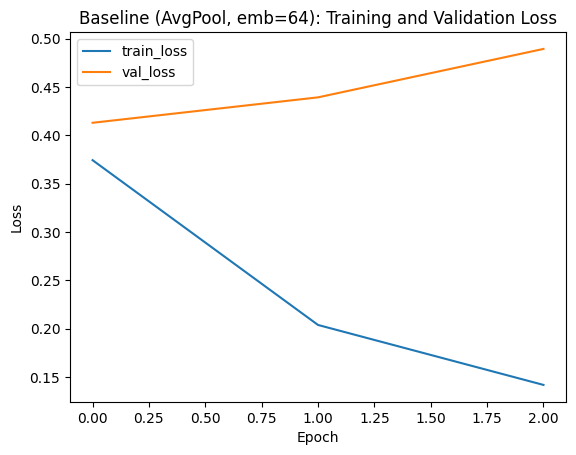

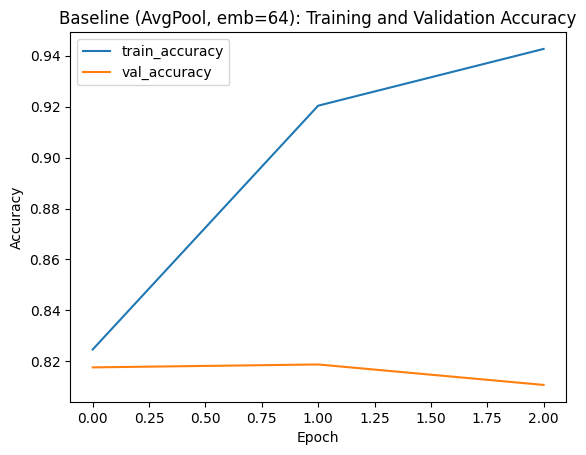

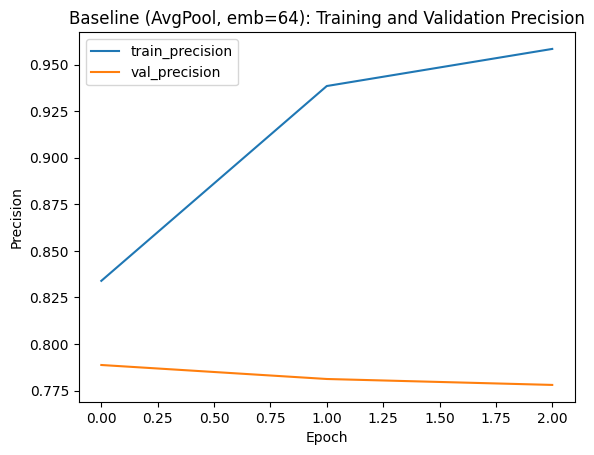

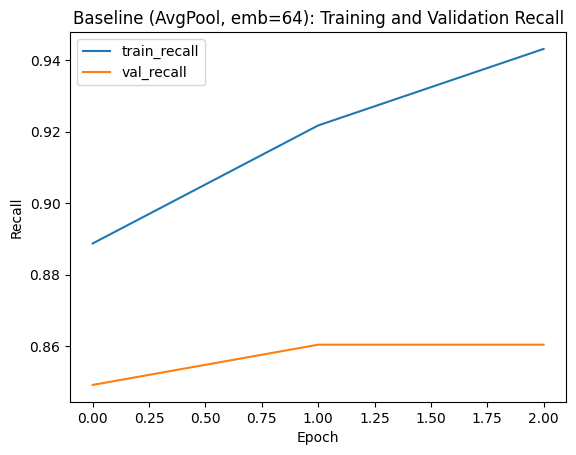


Baseline (AvgPool, emb=64) (threshold=0.6)
------------------------------------------
Accuracy : 0.8177
Precision: 0.8417
Recall   : 0.7905
F1-score : 0.8153
Confusion matrix:
[[362  66]
 [ 93 351]]
AUC (Baseline (AvgPool, emb=64)): 0.8959


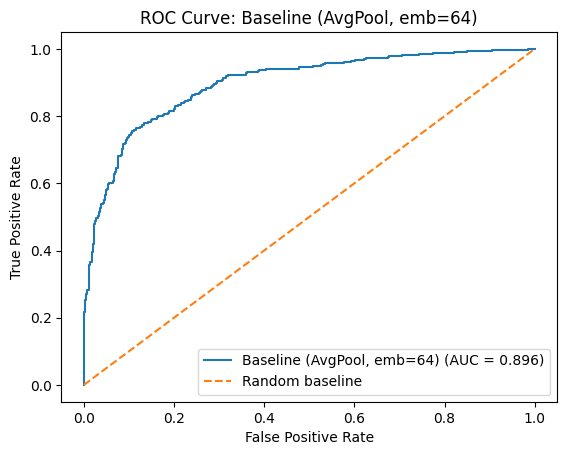

In [ ]:
THRESHOLD = 0.6
EPOCHS = 20

# Baseline (avg pooling, emb=64)
baseline_model = build_baseline_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=64,
    dense_units=64,
    threshold=THRESHOLD,
)

history_base = baseline_model.fit(
    train_ds_base,
    validation_data=val_ds_base,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_base = full_model_report(
    name="Baseline (AvgPool, emb=64)",
    model=baseline_model,
    history=history_base,
    val_ds=val_ds_base,
    threshold=THRESHOLD,
    plot_curves=True,
    plot_pr=True,
    plot_roc=True
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   1052/Unknown 43s 31ms/step - accuracy: 0.7199 - loss: 0.4840 - precision: 0.7352 - recall: 0.8947

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.7201 - loss: 0.4838 - precision: 0.7353 - recall: 0.8947 - val_accuracy: 0.8268 - val_loss: 0.4084 - val_precision: 0.7893 - val_recall: 0.8604 - learning_rate: 0.0010
Epoch 2/20
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9163 - loss: 0.2165 - precision: 0.9354 - recall: 0.9173
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9163 - loss: 0.2165 - precision: 0.9354 - recall: 0.9173 - val_accuracy: 0.8257 - val_loss: 0.4179 - val_precision: 0.8060 - val_recall: 0.8514 - learning_rate: 0.0010
Epoch 3/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9392 - loss: 0.1534 - precision: 0.9561 - recall: 0.9403
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9392 - loss: 0.1534 - precision: 0.9561 - recall: 0.9403 - val_accuracy: 0.8211 - v

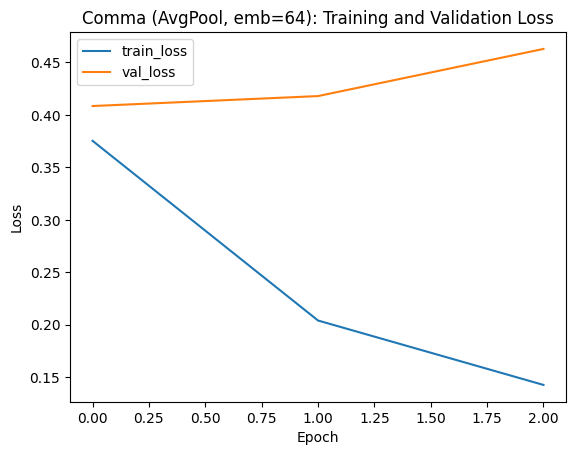

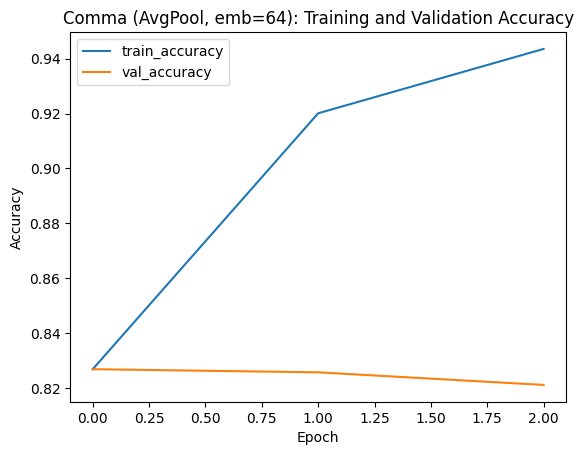

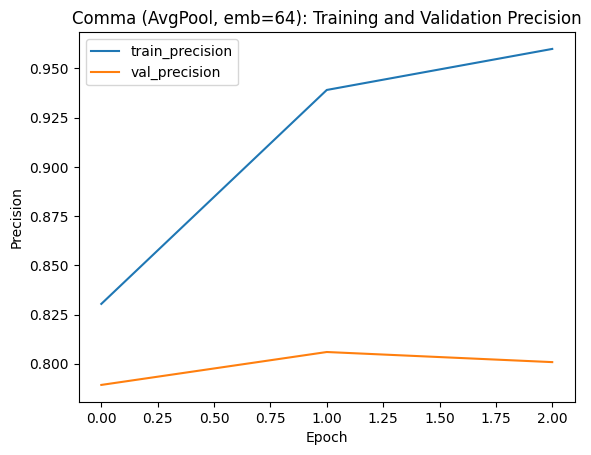

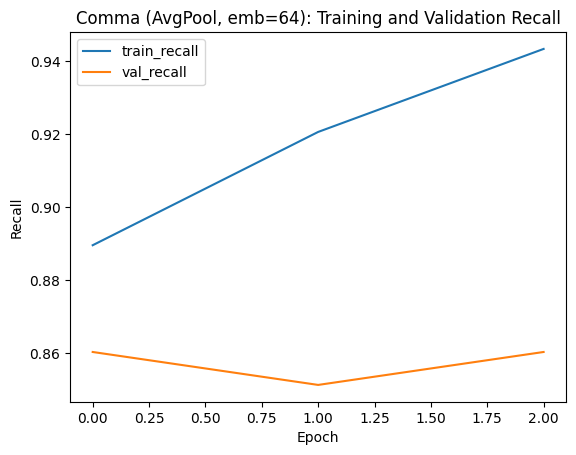


Comma (AvgPool, emb=64) (threshold=0.6)
---------------------------------------
Accuracy : 0.8268
Precision: 0.8368
Recall   : 0.8198
F1-score : 0.8282
Confusion matrix:
[[357  71]
 [ 80 364]]
AUC (Comma (AvgPool, emb=64)): 0.8984


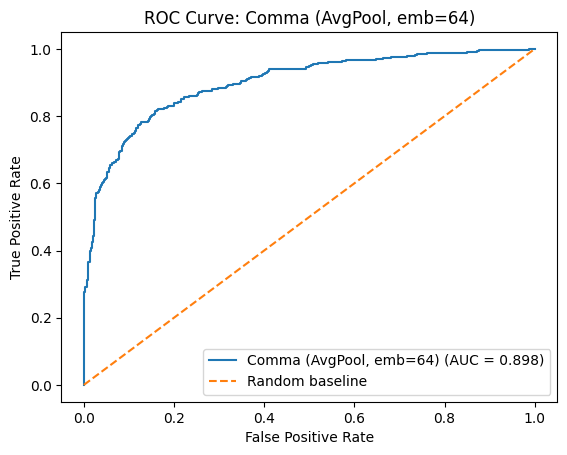

In [ ]:
# Comma model (same architecture, different vectorizer)
comma_model = build_baseline_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=64,
    dense_units=64,
    threshold=THRESHOLD,
)

history_comma = comma_model.fit(
    train_ds_comma,
    validation_data=val_ds_comma,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_comma = full_model_report(
    name="Comma (AvgPool, emb=64)",
    model=comma_model,
    history=history_comma,
    val_ds=val_ds_comma,
    threshold=THRESHOLD,
    plot_curves=True,
    plot_pr=True,
    plot_roc=True
)

AUC (Baseline (AvgPool, emb=64)): 0.8959
AUC (Comma (AvgPool, emb=64)): 0.8984


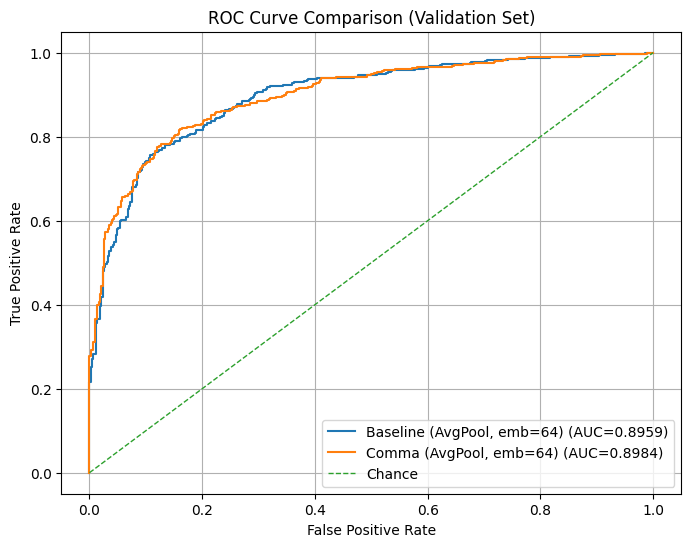

In [ ]:
# Compare Models
compare_models_roc(
    baseline_model, val_ds_base, "Baseline (AvgPool, emb=64)",
    comma_model, val_ds_comma, "Comma (AvgPool, emb=64)",
    return_dicts=False
)


In [ ]:
# Build a comparison table

rows = [
    report_to_row(report_base),
    report_to_row(report_comma),
]

results_df = pd.DataFrame(rows)

# Show sorted by F1 (you can change to "auc" or "accuracy")
results_df.sort_values(by="f1", ascending=False)


,model,threshold,accuracy,precision,recall,f1,tp,fp,tn,fn,auc
1,"Comma (AvgPool, emb=64)",0.6,0.826835,0.836782,0.819820,0.828214,364,71,357,80,0.898380
0,"Baseline (AvgPool, emb=64)",0.6,0.817661,0.841727,0.790541,0.815331,351,66,362,93,0.895907


### GlobalAvgPool + Emb(32)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   1050/Unknown 11s 9ms/step - accuracy: 0.7050 - loss: 0.4953 - precision: 0.7256 - recall: 0.9042

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7054 - loss: 0.4949 - precision: 0.7259 - recall: 0.9041 - val_accuracy: 0.8211 - val_loss: 0.4194 - val_precision: 0.7828 - val_recall: 0.8604 - learning_rate: 0.0010
Epoch 2/20
1050/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9151 - loss: 0.2245 - precision: 0.9331 - recall: 0.9178
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9151 - loss: 0.2244 - precision: 0.9332 - recall: 0.9179 - val_accuracy: 0.8131 - val_loss: 0.4469 - val_precision: 0.7780 - val_recall: 0.8761 - learning_rate: 0.0010
Epoch 3/20
1050/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9380 - loss: 0.1606 - precision: 0.9538 - recall: 0.9377
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9380 - loss: 0.1606 - precision: 0.9538 - recall: 0.9377 - val_accuracy: 0.8177 - val_lo

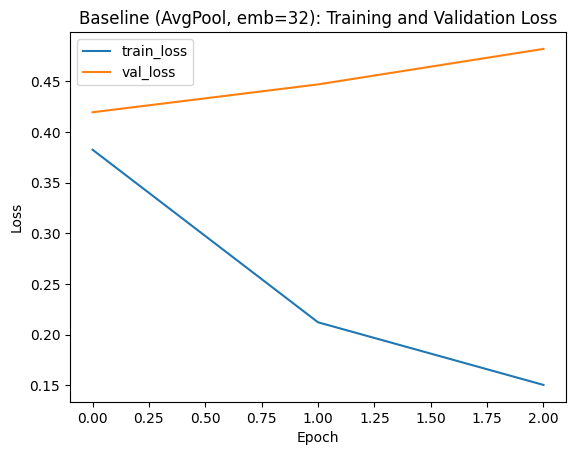

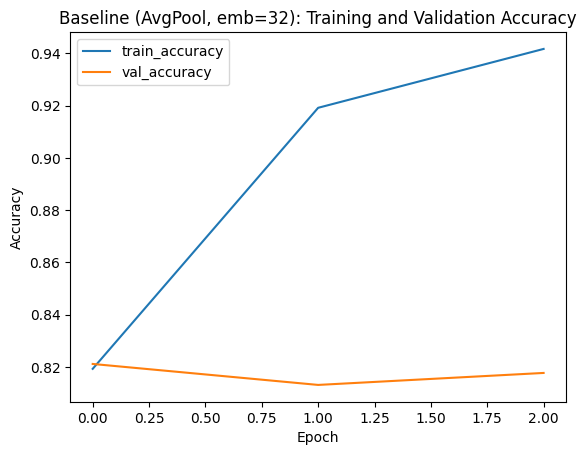

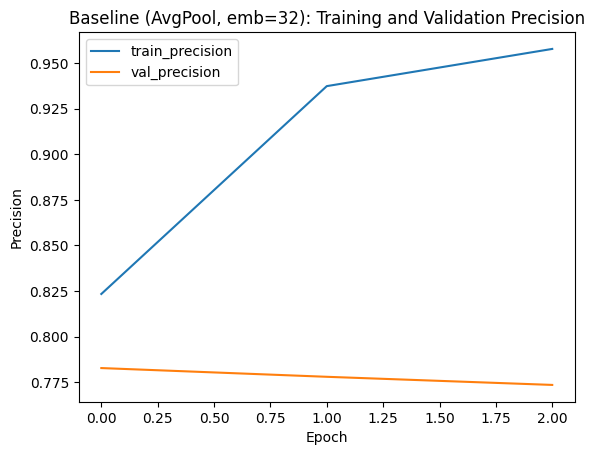

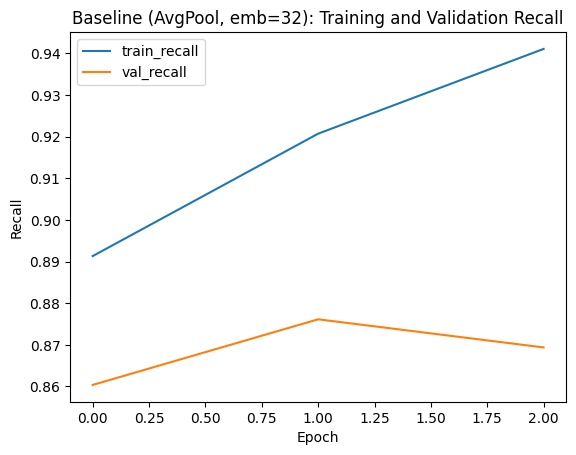


Baseline (AvgPool, emb=32) (threshold=0.6)
------------------------------------------
Accuracy : 0.8211
Precision: 0.8349
Recall   : 0.8086
F1-score : 0.8215
Confusion matrix:
[[357  71]
 [ 85 359]]
AUC (Baseline (AvgPool, emb=32)): 0.8941


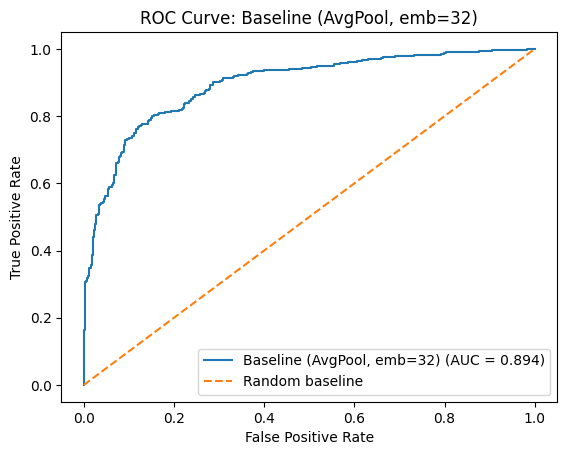

In [ ]:
THRESHOLD = 0.6
EPOCHS = 20

# uses baseline model's dataset vectorizer (commas removed)
baseline32_model = build_baseline_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=32,
    dense_units=64,   # keep same to isolate effect of embedding size
    threshold=THRESHOLD,
)

history_base32 = baseline32_model.fit(
    train_ds_base,
    validation_data=val_ds_base,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_base32 = full_model_report(
    name="Baseline (AvgPool, emb=32)",
    model=baseline32_model,
    history=history_base32,
    val_ds=val_ds_base,
    threshold=THRESHOLD
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   1049/Unknown 11s 9ms/step - accuracy: 0.7149 - loss: 0.4932 - precision: 0.7265 - recall: 0.9012

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7154 - loss: 0.4927 - precision: 0.7270 - recall: 0.9011 - val_accuracy: 0.8165 - val_loss: 0.4173 - val_precision: 0.7825 - val_recall: 0.8671 - learning_rate: 0.0010
Epoch 2/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9145 - loss: 0.2261 - precision: 0.9325 - recall: 0.9176
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9145 - loss: 0.2261 - precision: 0.9325 - recall: 0.9176 - val_accuracy: 0.8245 - val_loss: 0.4186 - val_precision: 0.7905 - val_recall: 0.8581 - learning_rate: 0.0010
Epoch 3/20
1050/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9385 - loss: 0.1651 - precision: 0.9535 - recall: 0.9379
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9385 - loss: 0.1651 - precision: 0.9535 - recall: 0.9380 - val_accuracy: 0.8165 - val_lo

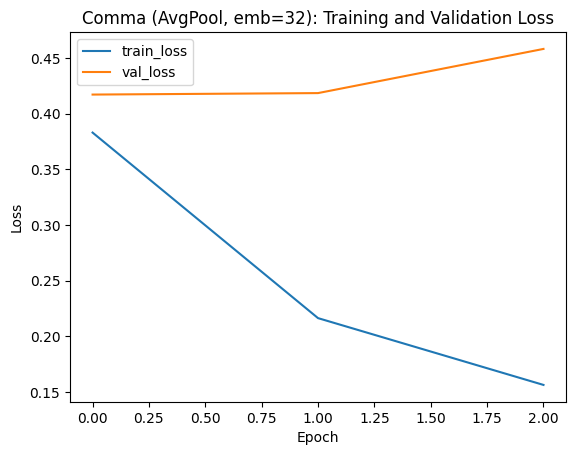

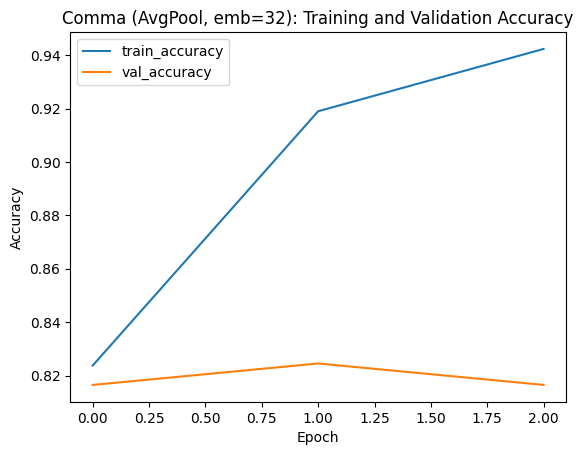

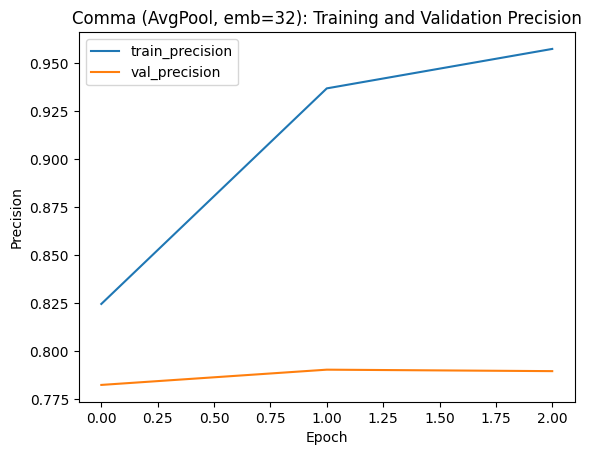

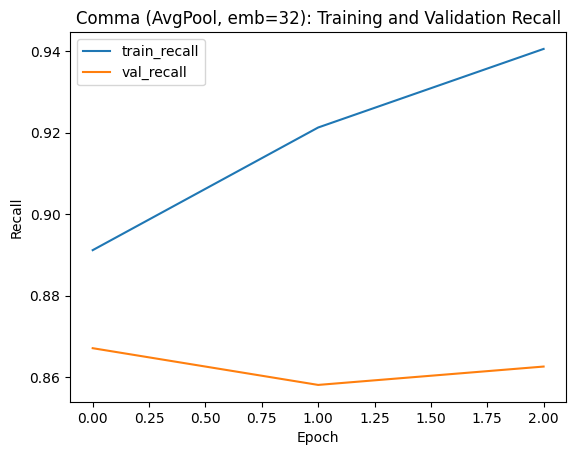


Comma (AvgPool, emb=32) (threshold=0.6)
---------------------------------------
Accuracy : 0.8165
Precision: 0.8198
Recall   : 0.8198
F1-score : 0.8198
Confusion matrix:
[[348  80]
 [ 80 364]]
AUC (Comma (AvgPool, emb=32)): 0.8964


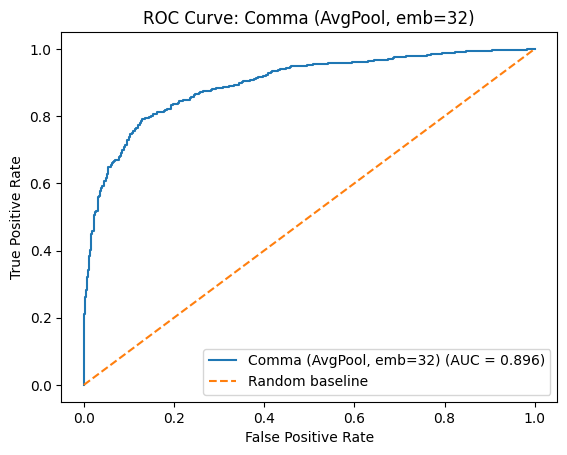

In [ ]:
# uses custom vectorizer (commas retained)

comma32_model = build_baseline_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=32,
    dense_units=64,
    threshold=THRESHOLD,
)

history_comma32 = comma32_model.fit(
    train_ds_comma,
    validation_data=val_ds_comma,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_comma32 = full_model_report(
    name="Comma (AvgPool, emb=32)",
    model=comma32_model,
    history=history_comma32,
    val_ds=val_ds_comma,
    threshold=THRESHOLD
)


AUC (Baseline (AvgPool, emb=32)): 0.8941
AUC (Comma (AvgPool, emb=32)): 0.8964


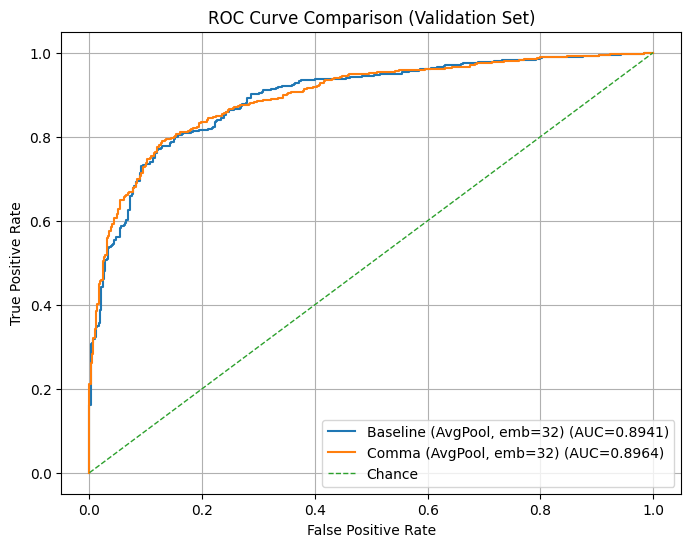

In [ ]:
_ = compare_models_roc(
    baseline32_model, val_ds_base, "Baseline (AvgPool, emb=32)",
    comma32_model, val_ds_comma, "Comma (AvgPool, emb=32)",
    return_dicts=False
)

In [ ]:
# Compare models to see if changing dimensionality improves model performance
print_delta("Baseline emb=32 - Baseline emb=64",
            report_base32["eval"], report_base["eval"])

print_delta("Comma emb=32 - Comma emb=64",
            report_comma32["eval"], report_comma["eval"])


Delta (Baseline emb=32 - Baseline emb=64):
Accuracy : +0.0034
Precision: -0.0068
Recall   : +0.0180
F1-score : +0.0062
ΔFP: 5
ΔFN: -8

Delta (Comma emb=32 - Comma emb=64):
Accuracy : -0.0103
Precision: -0.0170
Recall   : +0.0000
F1-score : -0.0084
ΔFP: 9
ΔFN: 0


In [ ]:
# add to results table
rows.extend([
    report_to_row(report_base32),
    report_to_row(report_comma32),
])

results_df = pd.DataFrame(rows)
results_df.sort_values(by="f1", ascending=False)


,model,threshold,accuracy,precision,recall,f1,tp,fp,tn,fn,auc
1,"Comma (AvgPool, emb=64)",0.6,0.826835,0.836782,0.819820,0.828214,364,71,357,80,0.898380
2,"Baseline (AvgPool, emb=32)",0.6,0.821101,0.834884,0.808559,0.821510,359,71,357,85,0.894128
3,"Comma (AvgPool, emb=32)",0.6,0.816514,0.819820,0.819820,0.819820,364,80,348,80,0.896391
0,"Baseline (AvgPool, emb=64)",0.6,0.817661,0.841727,0.790541,0.815331,351,66,362,93,0.895907


### GlobalAvgPool + Emb(128)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   1053/Unknown 42s 38ms/step - accuracy: 0.7389 - loss: 0.4637 - precision: 0.7614 - recall: 0.8837

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.7389 - loss: 0.4636 - precision: 0.7615 - recall: 0.8837 - val_accuracy: 0.8154 - val_loss: 0.4166 - val_precision: 0.7802 - val_recall: 0.8716 - learning_rate: 0.0010
Epoch 2/20
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9168 - loss: 0.2099 - precision: 0.9349 - recall: 0.9180
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9168 - loss: 0.2099 - precision: 0.9349 - recall: 0.9180 - val_accuracy: 0.8131 - val_loss: 0.4538 - val_precision: 0.7764 - val_recall: 0.8761 - learning_rate: 0.0010
Epoch 3/20
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9402 - loss: 0.1460 - precision: 0.9539 - recall: 0.9420
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9402 - loss: 0.1460 - precision: 0.9539 - recall: 0.9420 - val_accuracy: 0.8073 - v

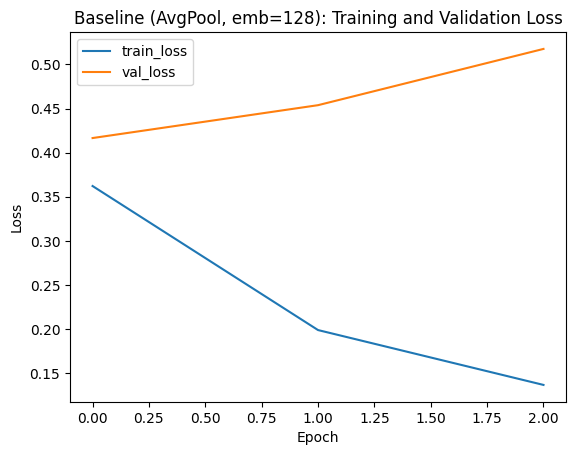

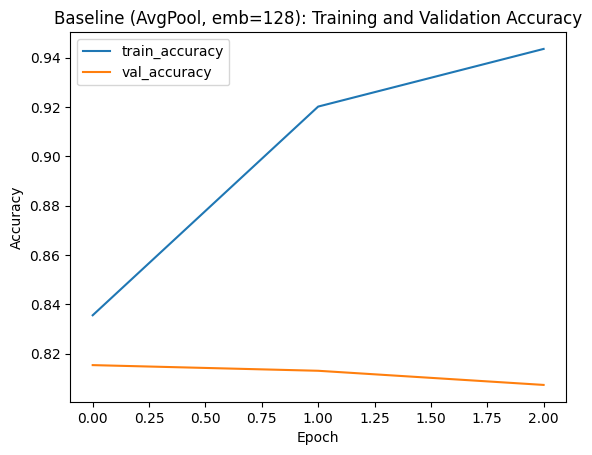

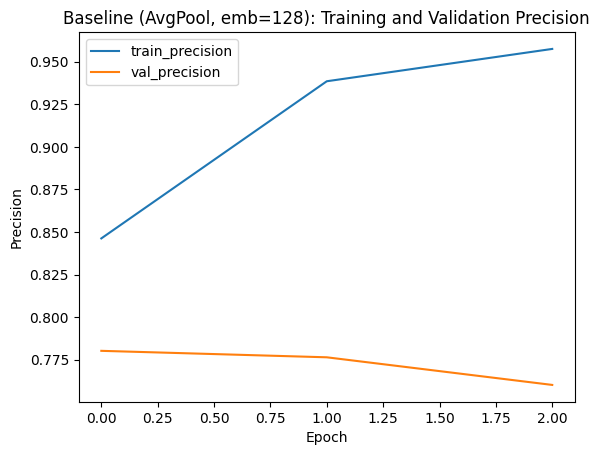

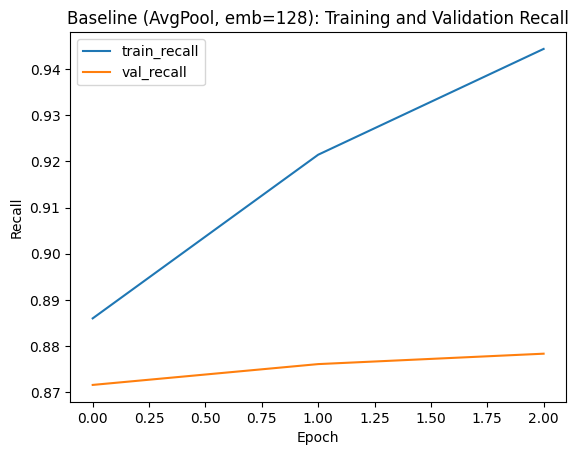


Baseline (AvgPool, emb=128) (threshold=0.6)
-------------------------------------------
Accuracy : 0.8154
Precision: 0.8223
Recall   : 0.8131
F1-score : 0.8177
Confusion matrix:
[[350  78]
 [ 83 361]]
AUC (Baseline (AvgPool, emb=128)): 0.8970


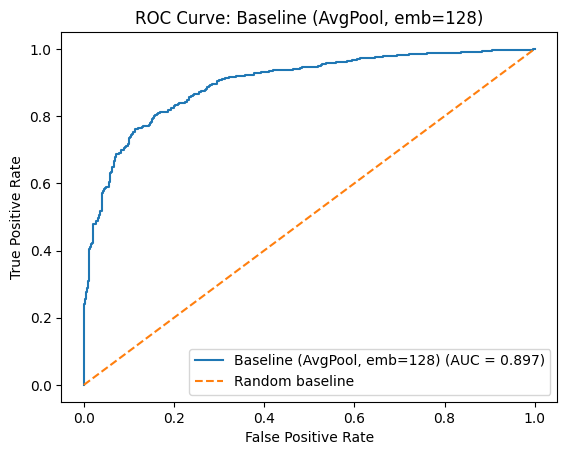

In [ ]:
THRESHOLD = 0.6
EPOCHS = 20

# standard vectorizer (no commas)
baseline128_model = build_baseline_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=128,
    dense_units=64,   # keep fixed to isolate embedding effect
    threshold=THRESHOLD,
)

history_base128 = baseline128_model.fit(
    train_ds_base,
    validation_data=val_ds_base,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_base128 = full_model_report(
    name="Baseline (AvgPool, emb=128)",
    model=baseline128_model,
    history=history_base128,
    val_ds=val_ds_base,
    threshold=THRESHOLD
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   1053/Unknown 44s 39ms/step - accuracy: 0.7462 - loss: 0.4641 - precision: 0.7555 - recall: 0.8958

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.7463 - loss: 0.4640 - precision: 0.7556 - recall: 0.8958 - val_accuracy: 0.8142 - val_loss: 0.4097 - val_precision: 0.7889 - val_recall: 0.8671 - learning_rate: 0.0010
Epoch 2/20
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9172 - loss: 0.2085 - precision: 0.9373 - recall: 0.9185
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.9172 - loss: 0.2085 - precision: 0.9373 - recall: 0.9185 - val_accuracy: 0.8211 - val_loss: 0.4164 - val_precision: 0.8064 - val_recall: 0.8536 - learning_rate: 0.0010
Epoch 3/20
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9399 - loss: 0.1477 - precision: 0.9564 - recall: 0.9405
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.9399 - loss: 0.1477 - precision: 0.9564 - recall: 0.9405 - val_accuracy: 0.8177 - v

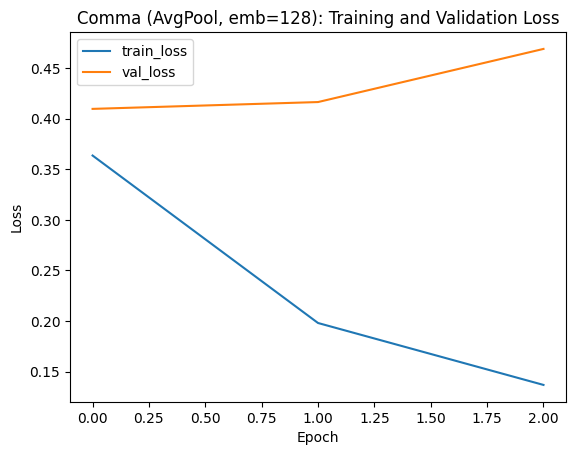

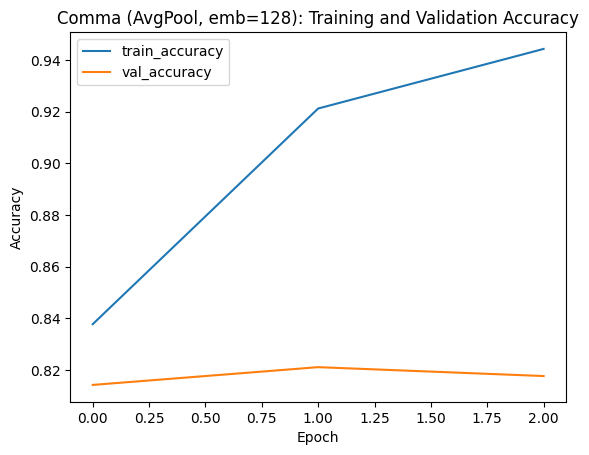

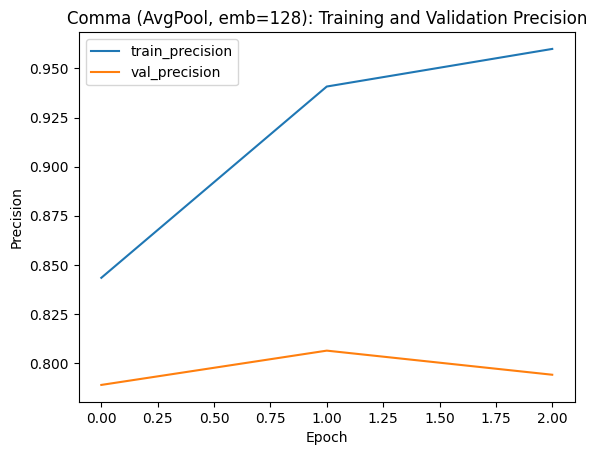

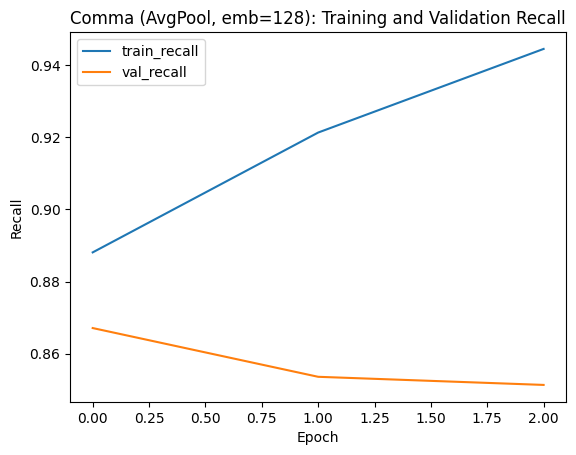


Comma (AvgPool, emb=128) (threshold=0.6)
----------------------------------------
Accuracy : 0.8142
Precision: 0.8176
Recall   : 0.8176
F1-score : 0.8176
Confusion matrix:
[[347  81]
 [ 81 363]]
AUC (Comma (AvgPool, emb=128)): 0.8994


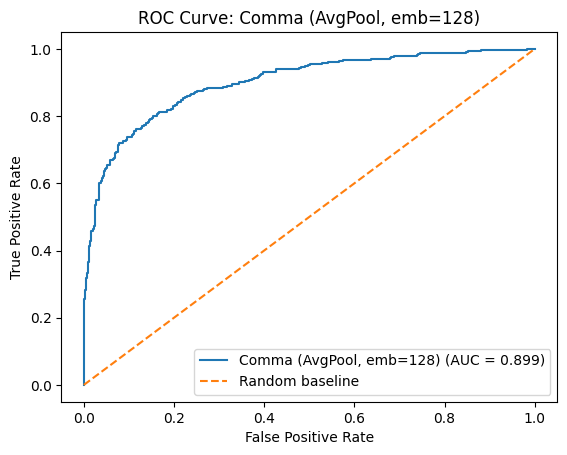

In [ ]:
# using custom vectorizer (commas retained)
comma128_model = build_baseline_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=128,
    dense_units=64,
    threshold=THRESHOLD,
)

history_comma128 = comma128_model.fit(
    train_ds_comma,
    validation_data=val_ds_comma,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_comma128 = full_model_report(
    name="Comma (AvgPool, emb=128)",
    model=comma128_model,
    history=history_comma128,
    val_ds=val_ds_comma,
    threshold=THRESHOLD
)


AUC (Baseline (AvgPool, emb=128)): 0.8970
AUC (Comma (AvgPool, emb=128)): 0.8994


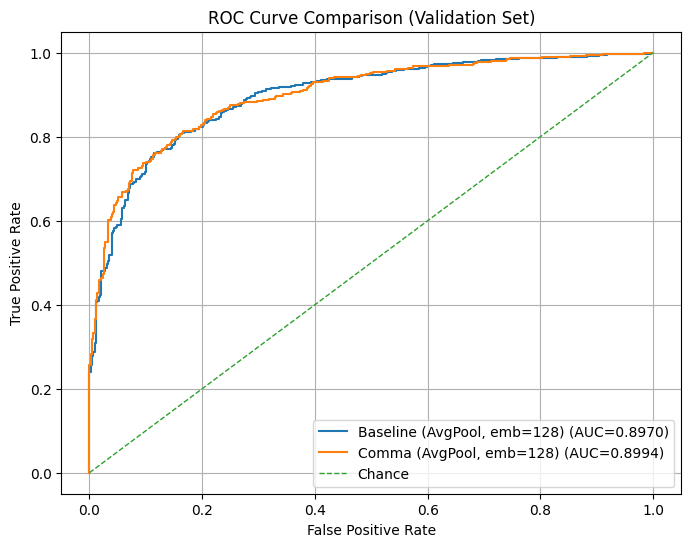

In [ ]:
_ = compare_models_roc(
    baseline128_model, val_ds_base, "Baseline (AvgPool, emb=128)",
    comma128_model, val_ds_comma, "Comma (AvgPool, emb=128)",
    return_dicts=False
)


In [ ]:
# add results to table
rows.extend([
    report_to_row(report_base128),
    report_to_row(report_comma128),
])

results_df = pd.DataFrame(rows)
results_df.sort_values(by="f1", ascending=False)


,model,threshold,accuracy,precision,recall,f1,tp,fp,tn,fn,auc
1,"Comma (AvgPool, emb=64)",0.6,0.826835,0.836782,0.819820,0.828214,364,71,357,80,0.898380
2,"Baseline (AvgPool, emb=32)",0.6,0.821101,0.834884,0.808559,0.821510,359,71,357,85,0.894128
3,"Comma (AvgPool, emb=32)",0.6,0.816514,0.819820,0.819820,0.819820,364,80,348,80,0.896391
4,"Baseline (AvgPool, emb=128)",0.6,0.815367,0.822323,0.813063,0.817667,361,78,350,83,0.897012
5,"Comma (AvgPool, emb=128)",0.6,0.814220,0.817568,0.817568,0.817568,363,81,347,81,0.899427
0,"Baseline (AvgPool, emb=64)",0.6,0.817661,0.841727,0.790541,0.815331,351,66,362,93,0.895907


In [ ]:
# compare models
print_delta("Baseline emb=128 - Baseline emb=64",
            report_base128["eval"], report_base["eval"])

print_delta("Comma emb=128 - Comma emb=64",
            report_comma128["eval"], report_comma["eval"])



Delta (Baseline emb=128 - Baseline emb=64):
Accuracy : -0.0023
Precision: -0.0194
Recall   : +0.0225
F1-score : +0.0023
ΔFP: 12
ΔFN: -10

Delta (Comma emb=128 - Comma emb=64):
Accuracy : -0.0126
Precision: -0.0192
Recall   : -0.0023
F1-score : -0.0106
ΔFP: 10
ΔFN: 1


## Interpretation of GlobalAvgPooling1D Models
Both models appear to have optimal performance at an intermediate embedding dimension (64).

Smaller embeddings underrepresent semantic information, while larger embeddings introduce unnecessary complexity without really improving generalization.

## **GlobalMaxPool1D + Emb(X) Models**

### GlobalMaxPool + Emb(64) (baseline)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


   1051/Unknown 20s 17ms/step - accuracy: 0.6834 - loss: 0.5008 - precision: 0.7020 - recall: 0.9263

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6838 - loss: 0.5004 - precision: 0.7023 - recall: 0.9263 - val_accuracy: 0.8165 - val_loss: 0.4256 - val_precision: 0.8047 - val_recall: 0.8536 - learning_rate: 0.0010
Epoch 2/20
1051/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9382 - loss: 0.1647 - precision: 0.9490 - recall: 0.9406
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9382 - loss: 0.1646 - precision: 0.9490 - recall: 0.9407 - val_accuracy: 0.8177 - val_loss: 0.4714 - val_precision: 0.7782 - val_recall: 0.8694 - learning_rate: 0.0010
Epoch 3/20
1051/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9677 - loss: 0.0942 - precision: 0.9751 - recall: 0.9679
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9677 - loss: 0.0942 - precision: 0.9751 - recall: 0.9679 - val_accuracy: 0.8211 - v

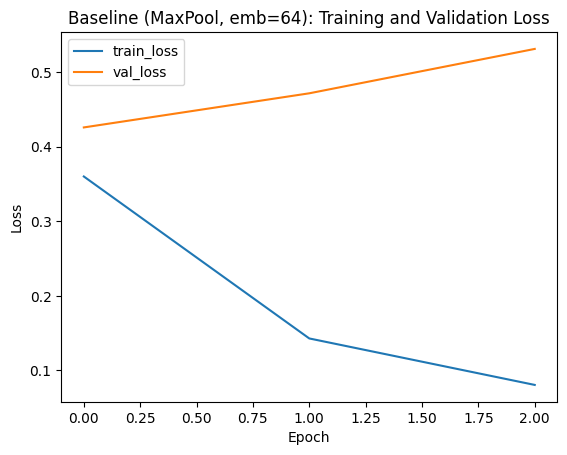

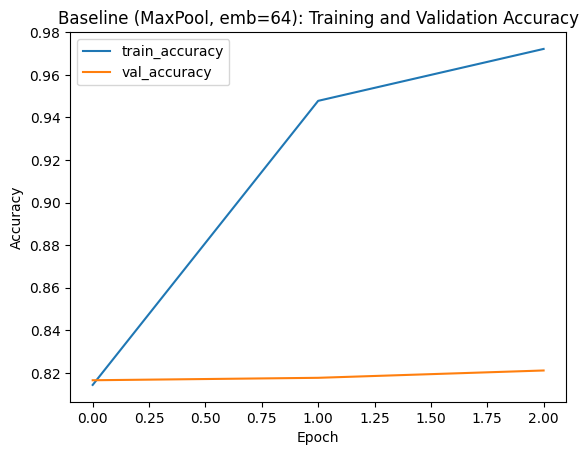

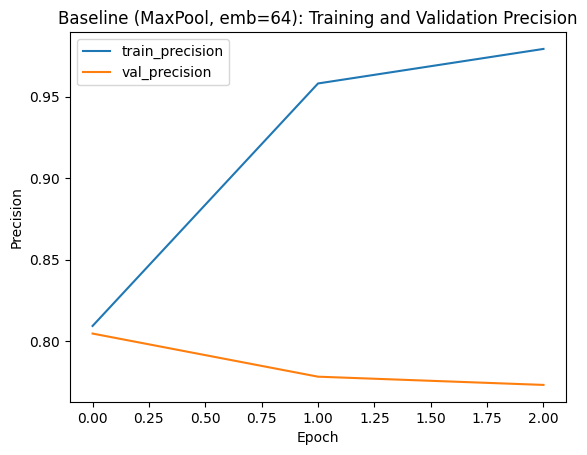

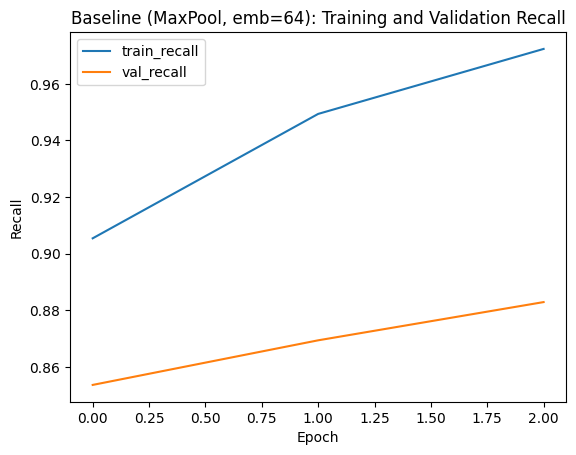


Baseline (MaxPool, emb=64) (threshold=0.6)
------------------------------------------
Accuracy : 0.8165
Precision: 0.8170
Recall   : 0.8243
F1-score : 0.8206
Confusion matrix:
[[346  82]
 [ 78 366]]
AUC (Baseline (MaxPool, emb=64)): 0.8984


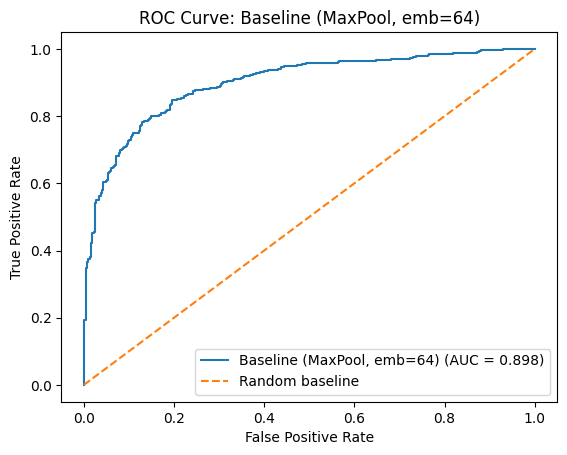

In [ ]:
THRESHOLD = 0.6
EPOCHS = 20

# standard vectorizer + baseline embedding = 64
baseline_max64_model = build_maxpool_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=64,
    dense_units=64,
    threshold=THRESHOLD,
)

history_base_max64 = baseline_max64_model.fit(
    train_ds_base,
    validation_data=val_ds_base,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_base_max64 = full_model_report(
    name="Baseline (MaxPool, emb=64)",
    model=baseline_max64_model,
    history=history_base_max64,
    val_ds=val_ds_base,
    threshold=THRESHOLD
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


   1051/Unknown 24s 20ms/step - accuracy: 0.6747 - loss: 0.5039 - precision: 0.7050 - recall: 0.9131

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.6751 - loss: 0.5035 - precision: 0.7053 - recall: 0.9131 - val_accuracy: 0.8234 - val_loss: 0.4088 - val_precision: 0.8112 - val_recall: 0.8514 - learning_rate: 0.0010
Epoch 2/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9371 - loss: 0.1652 - precision: 0.9493 - recall: 0.9403
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9371 - loss: 0.1652 - precision: 0.9493 - recall: 0.9403 - val_accuracy: 0.8326 - val_loss: 0.4362 - val_precision: 0.8241 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 3/20
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9667 - loss: 0.0937 - precision: 0.9749 - recall: 0.9672
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9667 - loss: 0.0937 - precision: 0.9749 - recall: 0.9672 - val_accuracy: 0.8291 - v

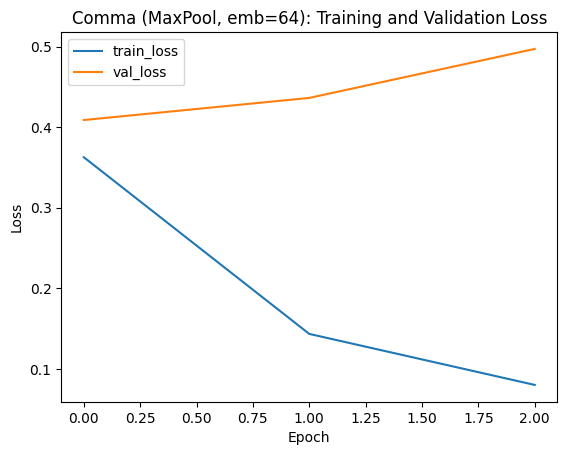

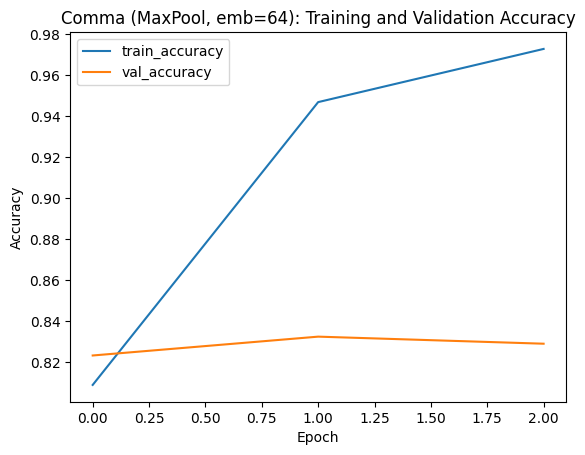

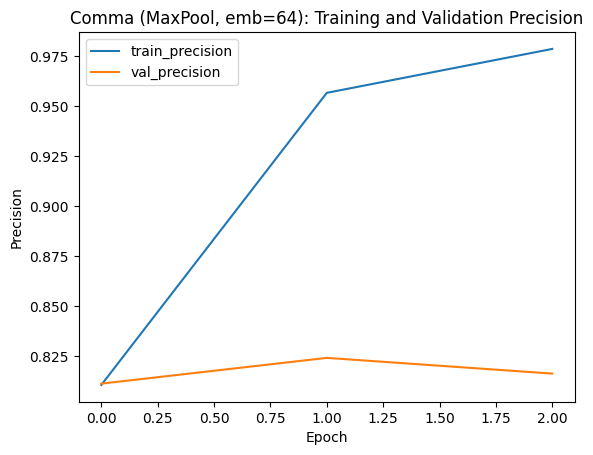

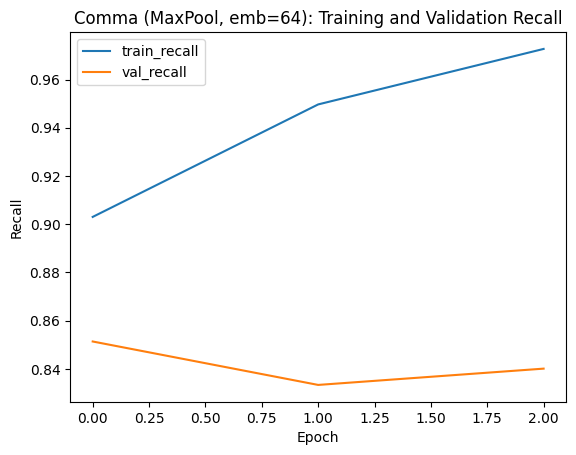


Comma (MaxPool, emb=64) (threshold=0.6)
---------------------------------------
Accuracy : 0.8234
Precision: 0.8356
Recall   : 0.8131
F1-score : 0.8242
Confusion matrix:
[[357  71]
 [ 83 361]]
AUC (Comma (MaxPool, emb=64)): 0.9032


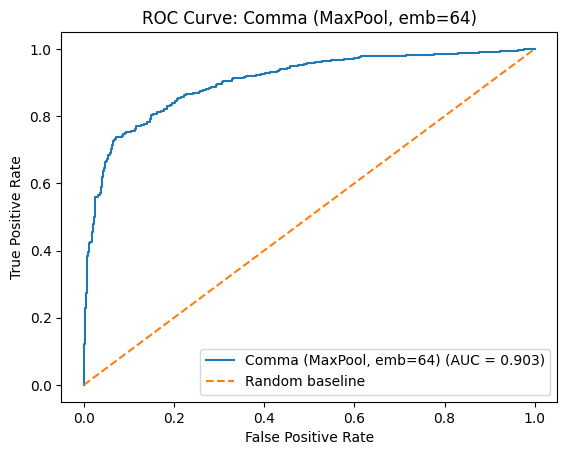

In [ ]:
# custom vectorizer (retaining commas) + baseline embeddings=64
comma_max64_model = build_maxpool_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=64,
    dense_units=64,
    threshold=THRESHOLD,
)

history_comma_max64 = comma_max64_model.fit(
    train_ds_comma,
    validation_data=val_ds_comma,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_comma_max64 = full_model_report(
    name="Comma (MaxPool, emb=64)",
    model=comma_max64_model,
    history=history_comma_max64,
    val_ds=val_ds_comma,
    threshold=THRESHOLD
)


AUC (Baseline (MaxPool, emb=64)): 0.8984
AUC (Comma (MaxPool, emb=64)): 0.9032


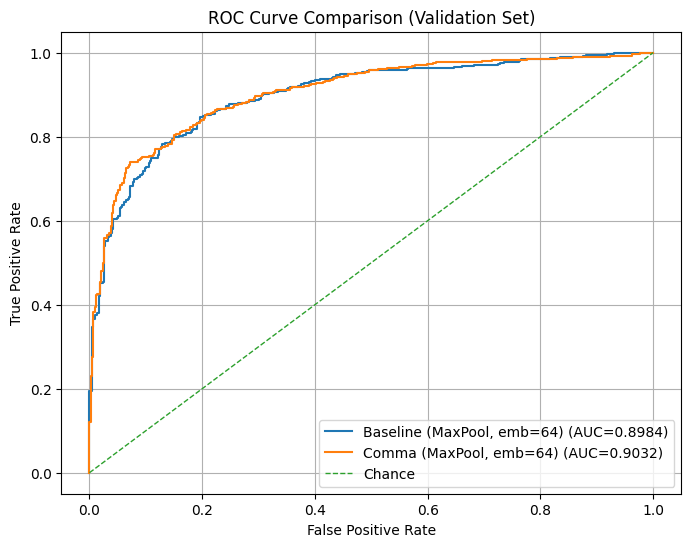

In [ ]:
_ = compare_models_roc(
    baseline_max64_model, val_ds_base, "Baseline (MaxPool, emb=64)",
    comma_max64_model, val_ds_comma, "Comma (MaxPool, emb=64)",
    return_dicts=False
)


In [ ]:
# add to results table
rows.extend([
    report_to_row(report_base_max64),
    report_to_row(report_comma_max64),
])

results_df = pd.DataFrame(rows)
results_df.sort_values(by="f1", ascending=False)


,model,threshold,accuracy,precision,recall,f1,tp,fp,tn,fn,auc
1,"Comma (AvgPool, emb=64)",0.6,0.826835,0.836782,0.819820,0.828214,364,71,357,80,0.898380
7,"Comma (MaxPool, emb=64)",0.6,0.823394,0.835648,0.813063,0.824201,361,71,357,83,0.903211
2,"Baseline (AvgPool, emb=32)",0.6,0.821101,0.834884,0.808559,0.821510,359,71,357,85,0.894128
6,"Baseline (MaxPool, emb=64)",0.6,0.816514,0.816964,0.824324,0.820628,366,82,346,78,0.898364
3,"Comma (AvgPool, emb=32)",0.6,0.816514,0.819820,0.819820,0.819820,364,80,348,80,0.896391
4,"Baseline (AvgPool, emb=128)",0.6,0.815367,0.822323,0.813063,0.817667,361,78,350,83,0.897012
5,"Comma (AvgPool, emb=128)",0.6,0.814220,0.817568,0.817568,0.817568,363,81,347,81,0.899427
0,"Baseline (AvgPool, emb=64)",0.6,0.817661,0.841727,0.790541,0.815331,351,66,362,93,0.895907


In [ ]:
print_delta(
    "Baseline MaxPool - AvgPool (emb=64)",
    report_base_max64["eval"],
    report_base["eval"]
)

print_delta(
    "Comma MaxPool - AvgPool (emb=64)",
    report_comma_max64["eval"],
    report_comma["eval"]
)



Delta (Baseline MaxPool - AvgPool (emb=64)):
Accuracy : -0.0011
Precision: -0.0248
Recall   : +0.0338
F1-score : +0.0053
ΔFP: 16
ΔFN: -15

Delta (Comma MaxPool - AvgPool (emb=64)):
Accuracy : -0.0034
Precision: -0.0011
Recall   : -0.0068
F1-score : -0.0040
ΔFP: 0
ΔFN: 3


Write a little bit about why you decided not test other embeddings

In [ ]:
### GlobalAvgPool + Emb(32) (baseline)

## GlobalMaxPooling Interpretation

GlobalAveragePooling1D consistently outperforms GlobalMaxPooling1D when models attempt to incorporate syntactic structure, whereas the baseline model shows only negligible sensitivity to pooling choice.

## **Regularization + GlobalAvgPool + Emb(X) Models**

### Reg + GlobalAvgPool + Emb(64)

In [ ]:
THRESHOLD = 0.6
EPOCHS = 20
TOKEN_DROPOUT_RATE = 0.05

reg_base_model = build_token_dropout_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=64,
    dense_units=64,
    token_dropout_rate=TOKEN_DROPOUT_RATE,
    threshold=THRESHOLD,
)

history_reg_base = reg_base_model.fit(
    train_ds_base,
    validation_data=val_ds_base,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_reg_base = full_model_report(
    name=f"Regularized Baseline (AvgPool, emb=64, token_dropout={TOKEN_DROPOUT_RATE})",
    model=reg_base_model,
    history=history_reg_base,
    val_ds=val_ds_base,
    threshold=THRESHOLD
)

print_delta(
    "Regularized Baseline - Baseline (AvgPool, emb=64)",
    report_reg_base["eval"],
    report_base["eval"]
)


NameError: name 'build_token_dropout_model' is not defined

### Reg Comma + GlobalAvgPool + Emb(64)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   1052/Unknown 19s 17ms/step - accuracy: 0.7140 - loss: 0.4927 - precision: 0.7307 - recall: 0.8980

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7142 - loss: 0.4925 - precision: 0.7309 - recall: 0.8980 - val_accuracy: 0.8165 - val_loss: 0.4145 - val_precision: 0.7844 - val_recall: 0.8604 - learning_rate: 0.0010
Epoch 2/20
1051/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9053 - loss: 0.2386 - precision: 0.9226 - recall: 0.9089
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9053 - loss: 0.2386 - precision: 0.9226 - recall: 0.9089 - val_accuracy: 0.8234 - val_loss: 0.4251 - val_precision: 0.8021 - val_recall: 0.8491 - learning_rate: 0.0010
Epoch 3/20
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9252 - loss: 0.1809 - precision: 0.9418 - recall: 0.9282
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9252 - loss: 0.1809 - precision: 0.9418 - recall: 0.9282 - val_accuracy: 0.8154 - v

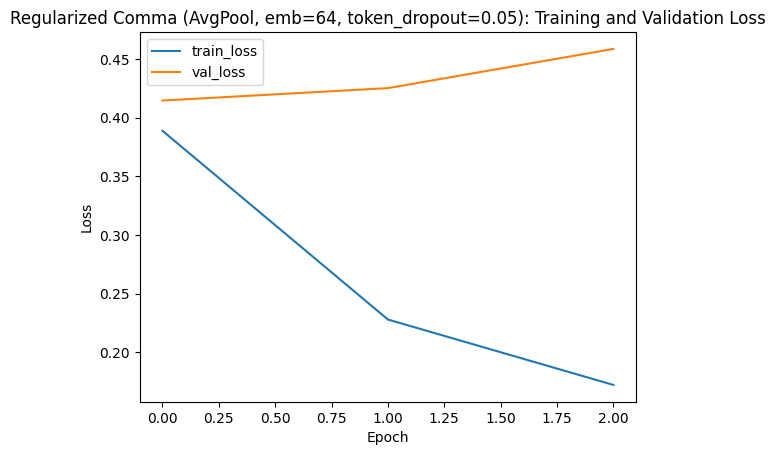

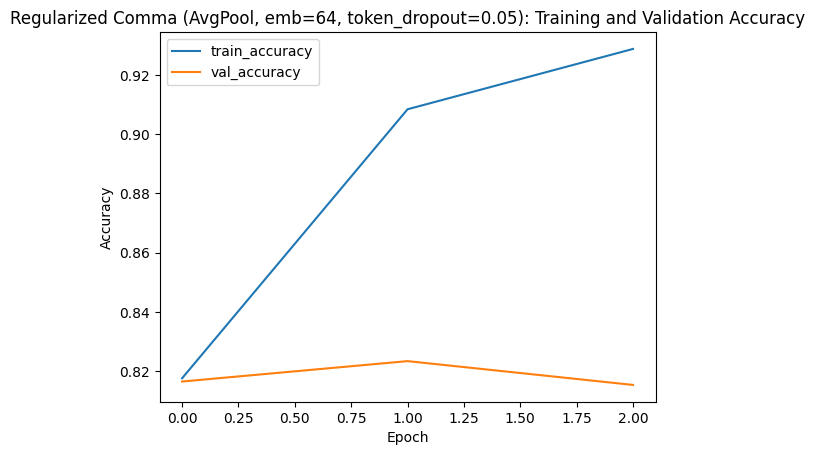

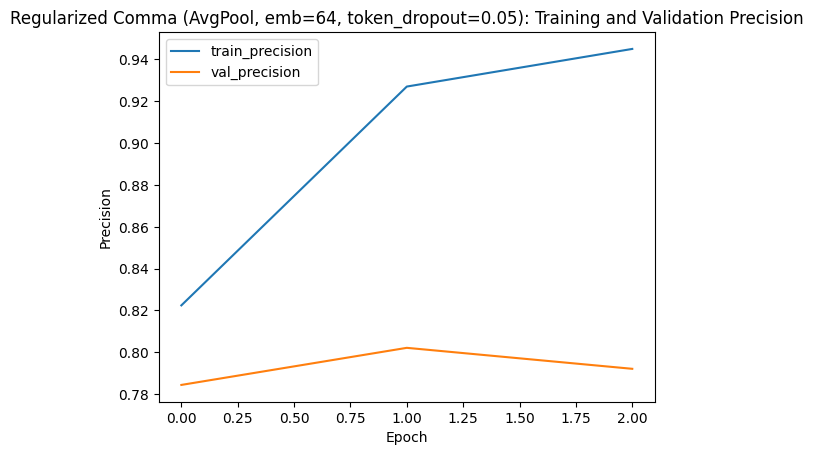

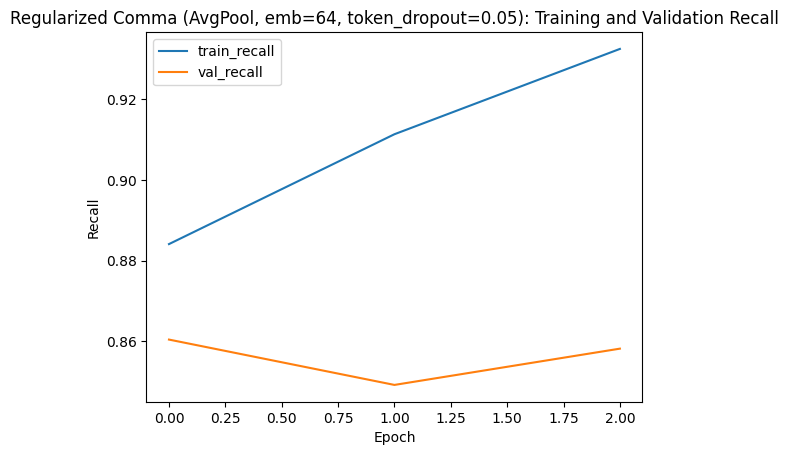


Regularized Comma (AvgPool, emb=64, token_dropout=0.05) (threshold=0.6)
-----------------------------------------------------------------------
Accuracy : 0.8165
Precision: 0.8213
Recall   : 0.8176
F1-score : 0.8194
Confusion matrix:
[[349  79]
 [ 81 363]]
AUC (Regularized Comma (AvgPool, emb=64, token_dropout=0.05)): 0.8961


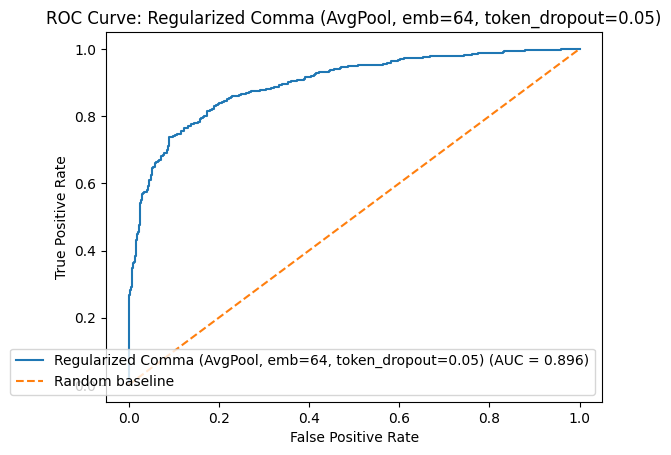


Delta (Regularized Comma - Comma (AvgPool, emb=64)):
Accuracy : -0.0103
Precision: -0.0155
Recall   : -0.0023
F1-score : -0.0088
ΔFP: 8
ΔFN: 1


In [ ]:
THRESHOLD = 0.6
EPOCHS = 20
TOKEN_DROPOUT_RATE = 0.05  # keep identical to the regularized baseline for a fair comparison

reg_comma_model = build_token_dropout_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=64,
    dense_units=64,
    token_dropout_rate=TOKEN_DROPOUT_RATE,
    threshold=THRESHOLD,
)

history_reg_comma = reg_comma_model.fit(
    train_ds_comma,
    validation_data=val_ds_comma,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_reg_comma = full_model_report(
    name=f"Regularized Comma (AvgPool, emb=64, token_dropout={TOKEN_DROPOUT_RATE})",
    model=reg_comma_model,
    history=history_reg_comma,
    val_ds=val_ds_comma,
    threshold=THRESHOLD
)

print_delta(
    "Regularized Comma - Comma (AvgPool, emb=64)",
    report_reg_comma["eval"],
    report_comma["eval"]
)


In [ ]:
rows.extend([
    report_to_row(report_reg_base),
    report_to_row(report_reg_comma),
])

results_df = pd.DataFrame(rows)
results_df.sort_values(by="f1", ascending=False)



,model,threshold,accuracy,precision,recall,f1,tp,fp,tn,fn,auc
1,"Comma (AvgPool, emb=64)",0.6,0.826835,0.836782,0.819820,0.828214,364,71,357,80,0.898380
7,"Comma (MaxPool, emb=64)",0.6,0.823394,0.835648,0.813063,0.824201,361,71,357,83,0.903211
2,"Baseline (AvgPool, emb=32)",0.6,0.821101,0.834884,0.808559,0.821510,359,71,357,85,0.894128
8,"Regularized Baseline (AvgPool, emb=64, token_d...",0.6,0.818807,0.825000,0.817568,0.821267,363,77,351,81,0.893097
6,"Baseline (MaxPool, emb=64)",0.6,0.816514,0.816964,0.824324,0.820628,366,82,346,78,0.898364
3,"Comma (AvgPool, emb=32)",0.6,0.816514,0.819820,0.819820,0.819820,364,80,348,80,0.896391
9,"Regularized Comma (AvgPool, emb=64, token_drop...",0.6,0.816514,0.821267,0.817568,0.819413,363,79,349,81,0.896123
4,"Baseline (AvgPool, emb=128)",0.6,0.815367,0.822323,0.813063,0.817667,361,78,350,83,0.897012
5,"Comma (AvgPool, emb=128)",0.6,0.814220,0.817568,0.817568,0.817568,363,81,347,81,0.899427
0,"Baseline (AvgPool, emb=64)",0.6,0.817661,0.841727,0.790541,0.815331,351,66,362,93,0.895907


### L2 Regularization on GlobalAvgPool + Emb(64) Models

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   1050/Unknown 20s 17ms/step - accuracy: 0.7327 - loss: 0.4789 - precision: 0.7379 - recall: 0.9065

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7330 - loss: 0.4785 - precision: 0.7382 - recall: 0.9064 - val_accuracy: 0.8131 - val_loss: 0.4189 - val_precision: 0.7856 - val_recall: 0.8581 - learning_rate: 0.0010
Epoch 2/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9162 - loss: 0.2175 - precision: 0.9353 - recall: 0.9192
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9162 - loss: 0.2175 - precision: 0.9353 - recall: 0.9192 - val_accuracy: 0.8108 - val_loss: 0.4526 - val_precision: 0.7785 - val_recall: 0.8626 - learning_rate: 0.0010
Epoch 3/20
1050/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9392 - loss: 0.1541 - precision: 0.9552 - recall: 0.9408
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9392 - loss: 0.1540 - precision: 0.9552 - recall: 0.9409 - val_accuracy: 0.8108 - v

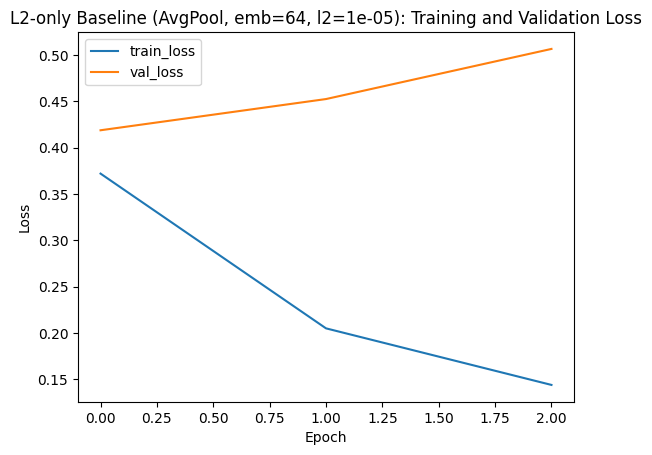

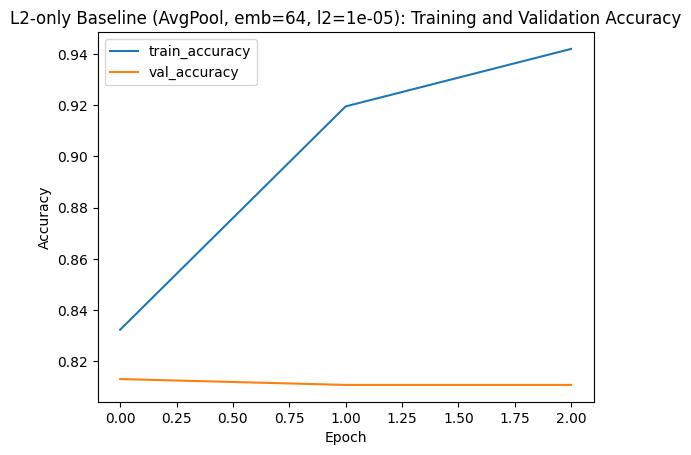

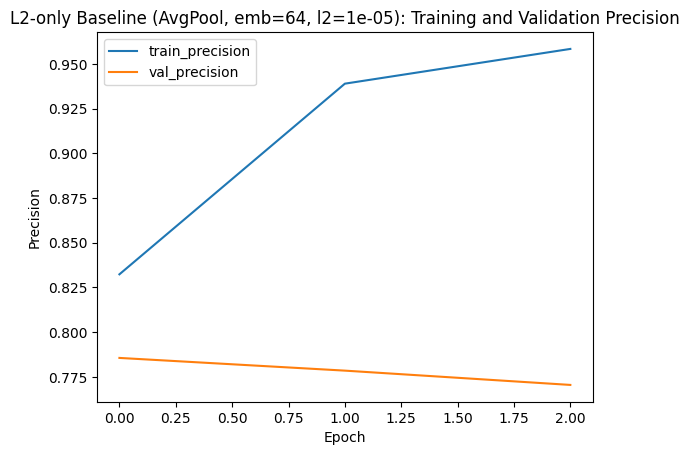

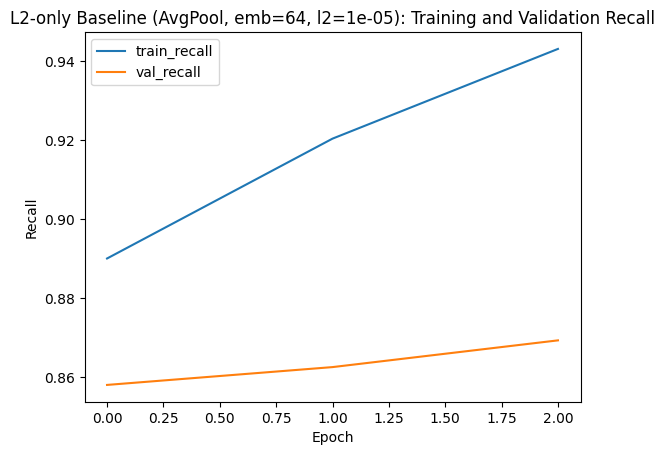


L2-only Baseline (AvgPool, emb=64, l2=1e-05) (threshold=0.6)
------------------------------------------------------------
Accuracy : 0.8131
Precision: 0.8260
Recall   : 0.8018
F1-score : 0.8137
Confusion matrix:
[[353  75]
 [ 88 356]]
AUC (L2-only Baseline (AvgPool, emb=64, l2=1e-05)): 0.8950


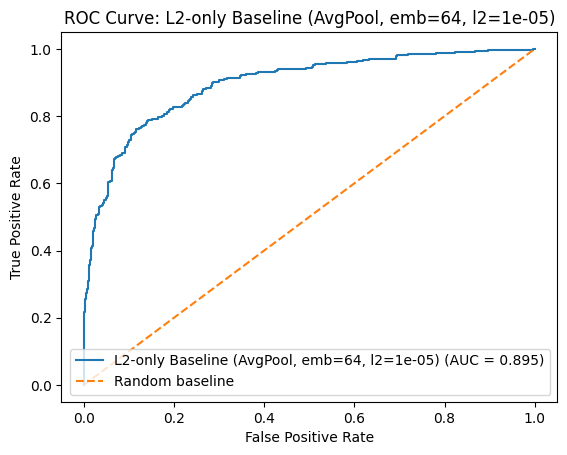


Delta (L2-only Baseline - Baseline (AvgPool, emb=64)):
Accuracy : -0.0046
Precision: -0.0157
Recall   : +0.0113
F1-score : -0.0016
ΔFP: 9
ΔFN: -5


In [ ]:
THRESHOLD = 0.6
EPOCHS = 20
L2_STRENGTH = 1e-5 #keep number very small to start

#L2 on baseline model
l2_base_model = build_l2_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=64,
    dense_units=64,
    l2_strength=L2_STRENGTH,
    threshold=THRESHOLD,
)

history_l2_base = l2_base_model.fit(
    train_ds_base,
    validation_data=val_ds_base,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_l2_base = full_model_report(
    name=f"L2-only Baseline (AvgPool, emb=64, l2={L2_STRENGTH})",
    model=l2_base_model,
    history=history_l2_base,
    val_ds=val_ds_base,
    threshold=THRESHOLD
)

print_delta(
    "L2-only Baseline - Baseline (AvgPool, emb=64)",
    report_l2_base["eval"],
    report_base["eval"]
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   1050/Unknown 18s 16ms/step - accuracy: 0.7276 - loss: 0.4801 - precision: 0.7409 - recall: 0.8997

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.7280 - loss: 0.4797 - precision: 0.7413 - recall: 0.8997 - val_accuracy: 0.8245 - val_loss: 0.4114 - val_precision: 0.7893 - val_recall: 0.8604 - learning_rate: 0.0010
Epoch 2/20
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9164 - loss: 0.2171 - precision: 0.9352 - recall: 0.9181
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.9164 - loss: 0.2171 - precision: 0.9353 - recall: 0.9181 - val_accuracy: 0.8268 - val_loss: 0.4150 - val_precision: 0.8030 - val_recall: 0.8536 - learning_rate: 0.0010
Epoch 3/20
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9377 - loss: 0.1562 - precision: 0.9539 - recall: 0.9401
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9377 - loss: 0.1562 - precision: 0.9539 - recall: 0.9401 - val_accuracy: 0.8222 - v

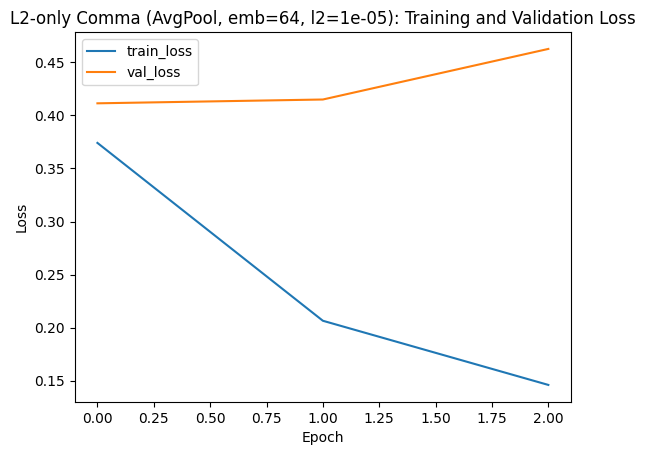

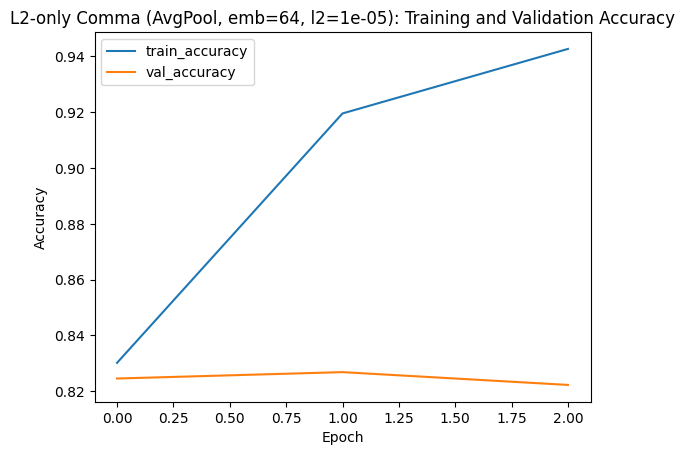

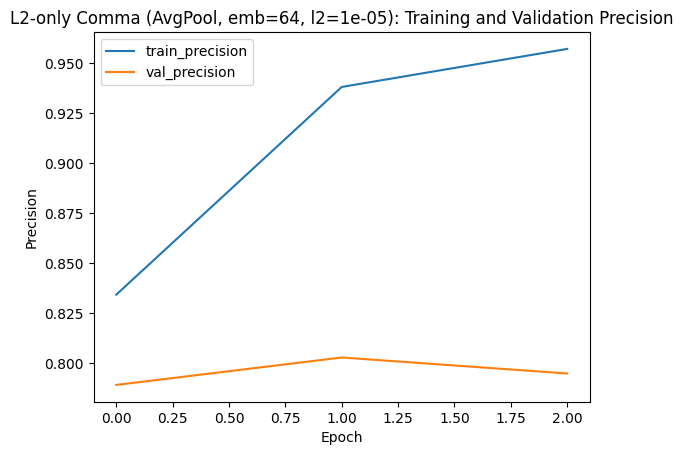

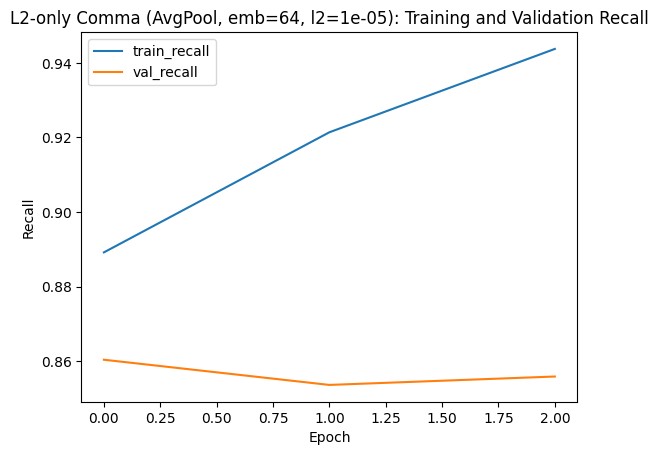


L2-only Comma (AvgPool, emb=64, l2=1e-05) (threshold=0.6)
---------------------------------------------------------
Accuracy : 0.8245
Precision: 0.8392
Recall   : 0.8108
F1-score : 0.8247
Confusion matrix:
[[359  69]
 [ 84 360]]
AUC (L2-only Comma (AvgPool, emb=64, l2=1e-05)): 0.8977


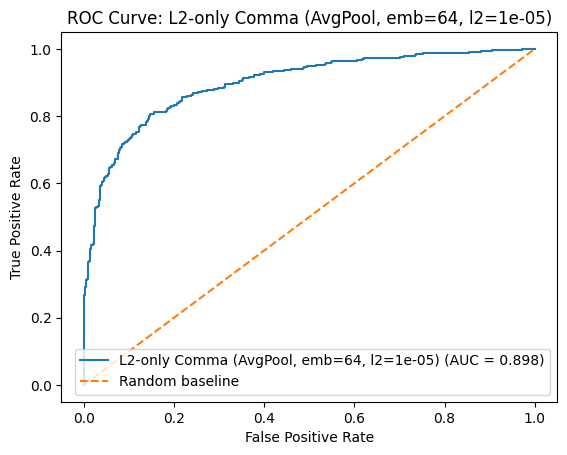


Delta (L2-only Comma - Comma (AvgPool, emb=64)):
Accuracy : -0.0023
Precision: +0.0024
Recall   : -0.0090
F1-score : -0.0035
ΔFP: -2
ΔFN: 4


In [ ]:
#L2 on comma model
l2_comma_model = build_l2_model(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=64,
    dense_units=64,
    l2_strength=L2_STRENGTH,
    threshold=THRESHOLD,
)

history_l2_comma = l2_comma_model.fit(
    train_ds_comma,
    validation_data=val_ds_comma,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

report_l2_comma = full_model_report(
    name=f"L2-only Comma (AvgPool, emb=64, l2={L2_STRENGTH})",
    model=l2_comma_model,
    history=history_l2_comma,
    val_ds=val_ds_comma,
    threshold=THRESHOLD
)

print_delta(
    "L2-only Comma - Comma (AvgPool, emb=64)",
    report_l2_comma["eval"],
    report_comma["eval"]
)


In [ ]:
rows.extend([
    report_to_row(report_l2_comma),
    report_to_row(report_l2_base),
])

results_df = pd.DataFrame(rows)
results_df.sort_values(by="f1", ascending=False)

,model,threshold,accuracy,precision,recall,f1,tp,fp,tn,fn,auc
1,"Comma (AvgPool, emb=64)",0.6,0.826835,0.836782,0.819820,0.828214,364,71,357,80,0.898380
10,"L2-only Comma (AvgPool, emb=64, l2=1e-05)",0.6,0.824541,0.839161,0.810811,0.824742,360,69,359,84,0.897670
7,"Comma (MaxPool, emb=64)",0.6,0.823394,0.835648,0.813063,0.824201,361,71,357,83,0.903211
2,"Baseline (AvgPool, emb=32)",0.6,0.821101,0.834884,0.808559,0.821510,359,71,357,85,0.894128
8,"Regularized Baseline (AvgPool, emb=64, token_d...",0.6,0.818807,0.825000,0.817568,0.821267,363,77,351,81,0.893097
6,"Baseline (MaxPool, emb=64)",0.6,0.816514,0.816964,0.824324,0.820628,366,82,346,78,0.898364
3,"Comma (AvgPool, emb=32)",0.6,0.816514,0.819820,0.819820,0.819820,364,80,348,80,0.896391
9,"Regularized Comma (AvgPool, emb=64, token_drop...",0.6,0.816514,0.821267,0.817568,0.819413,363,79,349,81,0.896123
4,"Baseline (AvgPool, emb=128)",0.6,0.815367,0.822323,0.813063,0.817667,361,78,350,83,0.897012
5,"Comma (AvgPool, emb=128)",0.6,0.814220,0.817568,0.817568,0.817568,363,81,347,81,0.899427


### Model Comparisons


In [ ]:
pretty_print_eval("Regularized Baseline", report_reg_base["eval"])
pretty_print_eval("Regularized Comma", report_reg_comma["eval"])



Regularized Baseline
--------------------
Accuracy : 0.8188
Precision: 0.8250
Recall   : 0.8176
F1-score : 0.8213
Confusion matrix:
[[351  77]
 [ 81 363]]

Regularized Comma
-----------------
Accuracy : 0.8165
Precision: 0.8213
Recall   : 0.8176
F1-score : 0.8194
Confusion matrix:
[[349  79]
 [ 81 363]]


In [ ]:
print_delta(
    "Regularized Comma - Regularized Baseline",
    report_reg_comma["eval"],
    report_reg_base["eval"]
)



Delta (Regularized Comma - Regularized Baseline):
Accuracy : -0.0023
Precision: -0.0037
Recall   : +0.0000
F1-score : -0.0019
ΔFP: 2
ΔFN: 0


AUC (Regularized Baseline): 0.8931
AUC (Regularized Comma): 0.8961


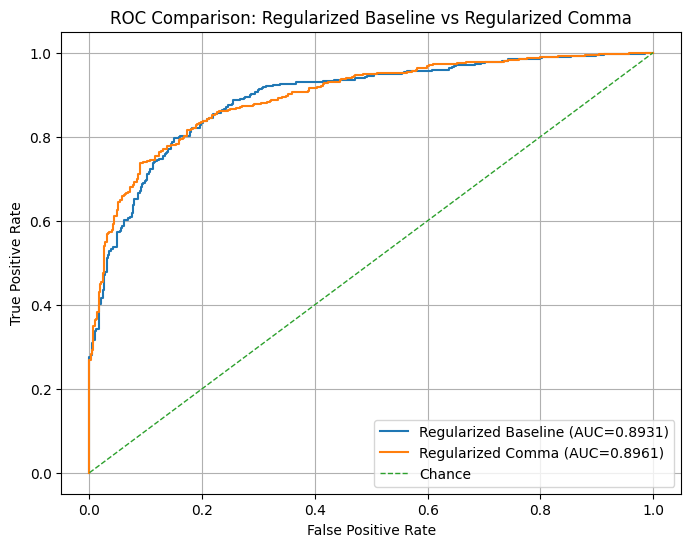

In [ ]:
_ = compare_models_roc(
    reg_base_model, val_ds_base, "Regularized Baseline",
    reg_comma_model, val_ds_comma, "Regularized Comma",
    title="ROC Comparison: Regularized Baseline vs Regularized Comma",
    return_dicts=False
)


## **Confidence Thresholding + Human Review in Action**

Automating sentiment classification without considering uncertainty can introduce risk, especially in customer-facing or high-stakes contexts. To address this, the system separates **model prediction** from **decision policy** by introducing a confidence threshold and a human review loop.

Rather than forcing the model to label every input, predictions are handled differently depending on how confident the model is in its output.

In [4]:
LABEL_THRESHOLD = 0.5
CONFIDENCE_THRESHOLD = 0.90

In [5]:
def confidence_from_probs(probs):
    return np.maximum(probs, 1 - probs)


#### How Confidence Is Used

For each input sentence, the model produces a probability of positive sentiment.  
Model confidence is defined as:

**Confidence = max(P(positive), 1 − P(positive))**

This value reflects how certain the model is in either direction.

#### Decision Policy

A configurable confidence threshold determines how predictions are handled:

- **Confidence ≥ threshold** → prediction is handled automatically  
- **Confidence < threshold** → prediction is routed to human review  

This ensures that automation is applied only where the model is most reliable.


#### Worked example

| Text                                    | P(Positive) | Predicted Label | Confidence | Action       |
| --------------------------------------- | ----------- | --------------- | ---------- | ------------ |
| “This update completely broke the app.” | 0.04        | Negative        | 0.96       | Auto-handled |
| “I love the new interface.”             | 0.97        | Positive        | 0.97       | Auto-handled |
| “Works fine for me.”                    | 0.88        | Positive        | 0.88       | Human review |
| “Not bad, but still pretty slow.”       | 0.58        | Positive        | 0.58       | Human review |
| “It’s okay, I guess.”                   | 0.52        | Positive        | 0.52       | Human review |

High-confidence predictions can be acted on immediately, while ambiguous cases benefit from human judgment.

#### Human Review Queue

Predictions below the confidence threshold are placed in a review queue and prioritized
by ambiguity (lowest confidence first). Reviewers assign the correct label and can
optionally add notes explaining the decision.

This process:

- reduces the risk of incorrect automation,  
- provides transparency and auditability, and  
- creates high-quality labeled data for future model improvement.


## **Linguistic Error Analysis**

In addition to quantitative metrics such as accuracy, precision, and recall, a qualitative inspection of model errors will be performed to better understand how the neural network interprets language. While aggregate metrics summarize overall performance, they do not reveal *why* the model makes certain mistakes or which linguistic phenomena are challenging for the chosen architecture.

In [ ]:
# inspect a few misclassifications
texts = []
true_labels = []

for text, label in ds_val.take(2000):
    texts.append(text.numpy().decode("utf-8"))
    true_labels.append(int(label.numpy()))

texts = np.array(texts)
true_labels = np.array(true_labels)

# Vectorize and predict
x_vec = vectorizer(tf.constant(texts))
probs = baseline_model.predict(x_vec, verbose=0).reshape(-1)
pred_labels = (probs >= 0.6).astype(int)

# Find errors
errors = np.where(pred_labels != true_labels)[0]
print("Misclassified in sample:", len(errors))

# Print a few examples for qualitative analysis
for idx in errors[:20]:
    print("-" * 80)
    print("Sentence:", texts[idx])
    print("True:", label_names[true_labels[idx]], "| Pred:", label_names[pred_labels[idx]],
          f"| P(positive)={probs[idx]:.3f}")

Misclassified in sample: 159
--------------------------------------------------------------------------------
Sentence: what is 100 % missing here is a script of even the most elemental literacy , an inkling of genuine wit , and anything resembling acting . 
True: negative | Pred: positive | P(positive)=0.622
--------------------------------------------------------------------------------
Sentence: care deftly captures the wonder and menace of growing up , but he never really embraces the joy of fuhrman 's destructive escapism or the grace-in-rebellion found by his characters . 
True: negative | Pred: positive | P(positive)=0.928
--------------------------------------------------------------------------------
Sentence: it haunts , horrifies , startles and fascinates ; it is impossible to look away . 
True: positive | Pred: negative | P(positive)=0.549
--------------------------------------------------------------------------------
Sentence: although huppert 's intensity and focus has a

Inspection of misclassified validation examples reveals a consistent linguistic pattern. Many errors involve sentences where sentiment shifts after a comma or contrastive phrase (e.g., “but”, “although”). Because the baseline model removes punctuation and uses average pooling, it cannot explicitly capture clause boundaries or sentiment reversals that occur later in the sentence. As a result, the model often overweights early positive cues and misclassifies sentences with late negative qualifiers.

### Qualitative Analysis - Linguistic Intuition

By decoding tokenized inputs back into human-readable text and comparing predicted and true sentiment labels, recurring linguistic patterns were identified:

-  **Adversative constructions**: Many sentences contain both positive and negative language, often joined by the clauses *but*, *although*, or *while*.
-  For example, the model misclassified this sentence as positive sentiment:
-  "irwin is a man with enough charisma and audacity to carry a dozen films , but this particular result is ultimately held back from being something greater. "
-  This is an example of contrastive coordination. This sentence is made up of two independent clauses that are linked by the conjunction *but*. Neither clause is syntactically subordinate to the other. The first clause "irwin is a man with enough charisma and audacity to carry a dozen films" carries positive sentiment, and the second clause "this particular result is ultimately held back from being something greater" has a negative sentiment. One clause establishes an expectation, but the other cancels or downgrades it. This means that the second clause has pragmatic dominance. Our model weighs sentiment language but does not properly handle the contrastive structure.  
-  **Sarcasm**: Sarcasm is negative sentiment expressed indirectly. The speaker meaning is not the literal meaning, and pragmatic inference is needed to interpret the message. For example, the model misclassified this sentence:
-  *i can take infantile humor ... but this is the sort of infantile that makes you wonder about changing the director and writer 's diapers.*
-  The model captures neutral or even positive sentiment tokens, but misses sarcastic intent.
-  **Negation scope**: Some sentences contain explicit negation, but the model still predicts positive. Negation reverses sentiment within its syntactic scope, not by adding a negative word (not, can't, never). For example, take this sentence:
-  *what the director can't do is make either of val kilmer's two personas interesting or worth caring about*
- **Domain-specific word choice**: Strong sentiment words can overpower context. Certain words can flip polarity depending on the domain. "Creepy" and "unsettling" are negative in isolation, but positive descriptors of horror films. This also informs the intuition to deploy a model using the GlobalMaxPoolingID1 layer, which takes the maximum value per embedding dimension across the sentence. If Average pooling asks "what is the overall tone of the sentence?", then Max pooling asks "is there any strong signal anywhere in the sentence?"
- **Understatement**: Negative sentiment can be expressed by lack, not presence. For example, *"so little movie"* and *"this isn't that"*

### Model Observations

These patterns highlight limitations of the baseline model in capturing syntactic structure and nuanced sentiment cues. The misclassifications arise from violating compositional, discourse, and pragmatic principles such as contrastive discourse, negation scope, sarcasm, and domain-dependent polarity. This is likely because of the loss of word order and hierarchical structure under GlobalAveragePooling.

## **Final Model Selection Justification**

Based on systematic experimentation and controlled comparisons, the **comma-preserving model with global average pooling** is selected as the final model.

This model achieved the best overall balance of accuracy, precision, and recall, improving performance across all metrics relative to the baseline without introducing tradeoffs. Unlike class weighting, which reduced false positives at the cost of significantly higher false negatives, preserving commas improved both error types simultaneously. This improvement aligns with earlier exploratory analysis and error inspection, which showed that commas frequently mark clause boundaries where sentiment shifts occur. By retaining these cues, the model was better able to capture contrastive sentiment without destabilizing probability calibration or requiring threshold retuning.

Alternative pooling strategies were evaluated to remain within a feed-forward architecture. Global max pooling slightly improved precision but did not outperform the comma-preserving average-pooling model overall. Concatenated average and max pooling increased model complexity without improving performance, suggesting that the added features introduced noise rather than useful signal for this dataset.

Importantly, the selected model maintains architectural simplicity: it uses a shallow feed-forward design, learns embeddings from scratch, and relies on a single pooling operation. As a result, performance gains can be attributed to improved input representation rather than increased model capacity, making the model both effective and interpretable within the constraints of the assignment.

Final choice:
Comma-preserving + GlobalAveragePooling1D (no class weighting, threshold = 0.6)